In [1]:
DATA_FILE = 'gold_data_1_class_dup.csv'
DOC_LANGUAGES = ['english', 'spanish', 'italian']
TITLE_FIELD = 'title'
DESCRIPTION_FIELD = 'description'
CONTENTS_FIELD = 'content'

In [93]:
import numpy as np
import pandas as pd
import re
import os
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
ps = PorterStemmer()
from collections import Counter
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_punctuation
from gensim import utils
from six import iteritems
import time
from itertools import islice
from gensim.models.phrases import Phrases, Phraser
from numbers import Number
import matplotlib.pyplot  as plt
import datetime
from gensim.corpora import Dictionary
import pickle



In [3]:
def log(msg, newFile):
    if newFile == True:
        with open('log.txt','w') as myfile:
            myfile.write(str(datetime.datetime.now()) + ' DEBUG: '+msg + '\n')
    else:
        with open("log.txt", "a") as myfile:
            myfile.write(str(datetime.datetime.now()) + ' DEBUG: '+msg + '\n')
        
log('Program start', True)

In [4]:
CUSTOM_FILTERS = [lambda x: x.lower(),stem_text,strip_multiple_whitespaces,
                  remove_stopwords, strip_punctuation,strip_non_alphanum,
                  strip_numeric]

In [5]:
def filterStopAndFreq(dictionary):
    stop_ids_english = [dictionary.token2id[stopword] for stopword in stopwords.words('english')
           if stopword in dictionary.token2id]
    stop_ids_spanish = [dictionary.token2id[stopword] for stopword in stopwords.words('spanish')
           if stopword in dictionary.token2id]
    stop_ids_italian = [dictionary.token2id[stopword] for stopword in stopwords.words('italian')
           if stopword in dictionary.token2id]
    log('[filterStopAndFreq].Stop words were added', False)
    once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
    log('[filterStopAndFreq].Unfrequent ids were added', False)
    
    dictionary.filter_tokens(stop_ids_english + stop_ids_spanish + stop_ids_italian + once_ids)
    log('[filterStopAndFreq].Done filtering tokens', False)
    
    return dictionary

In [6]:
def filterExtremes(dictionary, noBelow, noAbove):
    dictionary.filter_extremes(no_below=noBelow,no_above=noBelow)
    dictionary.compactify()
    dictionary.save('./deerwester.dict')  # store the dictionary, for future reference
    log('[filterExtremes].Dictionary has been saved', False)
    log('[filterExtremes].Done filtering extreme tokens', False)
    return dictionary

In [64]:
def createTokenDictionary(df, fieldName):
    log('[createTokenDictionary].Start Creating dictionary', False)
    row = df[fieldName].dropna()
    dictionary = corpora.Dictionary(preprocess_string(line, CUSTOM_FILTERS) for line in row)
    dictionary = filterStopAndFreq(dictionary)
    dictionary = filterExtremes(dictionary, 5, 0.1)
    log('[createTokenDictionary].Done Creating dictionary', False)
    
    return dictionary

In [8]:
def createVectorDataFrame(df, dictionary):
    log('[createVectorDataFrame].Start creating partial int vector data frame', False)
    titlesVectors = pd.DataFrame(columns=['vector','class'])
    for index, row in df.iterrows():
        if type(row['title']) is str:
            s = preprocess_string(row['title'], CUSTOM_FILTERS)
            vec = dictionary.doc2idx(s)
            # add class str
            titlesVectors = titlesVectors.append({'class': str(row['class']), 'vector': vec}, ignore_index= True)
    log('[createVectorDataFrame].Done creating partial int vector data frame', False)
        
    return titlesVectors
            

In [9]:
def getMaxVectorSize(intDf):
    log('[getMaxVectorSize].Getting max vector size', False)
    max = 0
    for index, row in intDf.iterrows():
        if (len(row['vector'])) > max:
            max = len(row['vector'])
    log('[getMaxVectorSize].Done getting max vector size - (maxSize) => ' + str(max), False)
    
    return max

In [34]:
def createVectorParts(intDf, maxVectorSize):
    log('[createVectorParts].Start creating vector parts', False)
    vectorPartsDf = pd.DataFrame()
    count = 0
    for index, row in intDf.iterrows():
        count += 1
        push = {}
        for i  in range(0,maxVectorSize):
            if i <= len(row['vector']) - 1 and row['vector'][i] >= 0:
                push[i] = row['vector'][i]
            else:
                push[i] = 0
        if isinstance(row['class'], str):
            # for all data
            #if row['class'] == '0.0:'
            #for Overexpressed in 1 data
            if row['class'] == '0':
                push['class'] = False
            else:
                push['class'] = True
        else:
            push['class'] = True
        print(count, push['class'])
        if isinstance(row['class'], str):
            vectorPartsDf = vectorPartsDf.append(push, ignore_index= True)
    log('[createVectorParts].Done creating vector parts', False)
    return vectorPartsDf

In [11]:
def trainTreeClassifier(vectorPartsDf, testSize):
    log('[trainTreeClassifier].Training Tree model for (testSize) => ' +str(testSize), False)
    from sklearn.model_selection import train_test_split
    X = vectorPartsDf.drop('class',axis=1)
    y = vectorPartsDf['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)
    
    from sklearn.tree import DecisionTreeClassifier
    dtree = DecisionTreeClassifier()
    dtree.fit(X_train,y_train)
    
    predictions = dtree.predict(X_test)
    from sklearn.metrics import classification_report,confusion_matrix
    print(classification_report(y_test,predictions))
    print(confusion_matrix(y_test,predictions))
    log('[trainTreeClassifier].Done Training Tree model for (testSize) => ' +str(testSize), False)

In [95]:
def trainRandomForest(vectorPartsDf, amountTrees):
    log('[trainRandomForest].Training Random forest model for (amountTrees) => ' +str(amountTrees), False)
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    X = vectorPartsDf.drop('class',axis=1)
    y = vectorPartsDf['class']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators=amountTrees)
    rfc.fit(X_train, y_train)
    
    rfc_pred = rfc.predict(X_test)
    print(classification_report(y_test,rfc_pred))
    print(confusion_matrix(y_test,rfc_pred))
    log('[trainRandomForest].Done Training Random forest model for (amountTrees) => ' +str(amountTrees), False)
    
    return rfc

In [13]:
def trainKnnClassifier(vectorPartsDf, testSize, n):
    log('[trainKnnClassifier].Training KNN model for (testSize,n) => ' +str(testSize) + ' , '+str(n), False)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(vectorPartsDf.drop('class',axis=1))
    scaled_features = scaler.transform(vectorPartsDf.drop('class',axis=1))
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(scaled_features,vectorPartsDf['class'],test_size=testSize)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    from sklearn.metrics import classification_report,confusion_matrix
    print(classification_report(y_test,pred))
    print(confusion_matrix(y_test,pred))
    log('[trainKnnClassifier].Done Training KNN model for (testSize,n) => ' +str(testSize) + ' , '+str(n), False)

In [14]:
def findBestKForKnn(vectorPartsDf):
    log('[findBestKForKnn].Calculating best k for KNN model', False)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(vectorPartsDf.drop('class',axis=1))
    scaled_features = scaler.transform(vectorPartsDf.drop('class',axis=1))
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(scaled_features,vectorPartsDf['class'], test_size=0.3)
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import classification_report,confusion_matrix
    
    # find best n
    error_rate = []
    
    for i in range(1,40):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train,y_train)
        pred_i = knn.predict(X_test)
        error_rate.append(np.mean(pred_i != y_test))
    
    plt.figure(figsize=(10,6))
    plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    log('[findBestKForKnn].Done Calculating best k for KNN model', False)

In [84]:
def saveTitlesDictionary(titlesDictionary):
    for sort_by_word in [True, aFalse]:
        titlesDictionary.save_as_text('dic.txt', sort_by_word=sort_by_word)

In [104]:
def saveRandomForestModel(rfModel):
    filename = 'rfModel.sav'
    pickle.dump(rfModel, open('rfModel.sav', 'wb'))

In [89]:
def loadTitlesDictionary():
    for sort_by_word in [True, False]:
        d_loaded = Dictionary.load_from_text('dic.txt')
        
    return d_loaded

In [105]:
def loadRandomForestClassifier():
    loaded_model = pickle.load(open('rfModel.sav', 'rb'))
    
    return loaded_model

In [15]:
df = pd.read_csv(DATA_FILE, encoding = "ISO-8859-1", engine='python', error_bad_lines=False)

In [65]:
titlesDictionary = createTokenDictionary(df, TITLE_FIELD)

In [87]:
saveTitlesDictionary(titlesDictionary)

In [17]:
descriptionsDictionary = createTokenDictionary(df, DESCRIPTION_FIELD)

In [18]:
contentsDictionary = createTokenDictionary(df, CONTENTS_FIELD)

In [19]:
intDfTitles = createVectorDataFrame(df, titlesDictionary)

In [20]:
intDfDescription = createVectorDataFrame(df, descriptionsDictionary)

In [21]:
intDfContent = createVectorDataFrame(df, contentsDictionary)

In [22]:
maxVectorSizeTitles = getMaxVectorSize(intDfTitles)

In [23]:
maxVectorSizeContents = getMaxVectorSize(intDfContent)

In [24]:
maxVectorSizeDescription = getMaxVectorSize(intDfDescription)

In [35]:
vectorPartsDfTitles = createVectorParts(intDfTitles, maxVectorSizeTitles)


1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False
111 Fals

833 False
834 False
835 False
836 False
837 False
838 False
839 False
840 False
841 False
842 False
843 False
844 False
845 False
846 False
847 False
848 False
849 False
850 False
851 False
852 False
853 False
854 False
855 False
856 False
857 False
858 False
859 False
860 False
861 False
862 False
863 False
864 False
865 False
866 False
867 False
868 False
869 False
870 False
871 False
872 False
873 False
874 False
875 False
876 False
877 False
878 False
879 False
880 False
881 False
882 False
883 False
884 False
885 False
886 False
887 False
888 False
889 False
890 False
891 False
892 False
893 False
894 False
895 False
896 False
897 False
898 False
899 False
900 False
901 False
902 False
903 False
904 False
905 False
906 False
907 False
908 False
909 False
910 False
911 False
912 False
913 False
914 False
915 False
916 False
917 False
918 False
919 False
920 False
921 False
922 False
923 False
924 False
925 False
926 False
927 False
928 False
929 False
930 False
931 False
932 False


1597 False
1598 False
1599 False
1600 False
1601 False
1602 False
1603 False
1604 False
1605 False
1606 False
1607 False
1608 False
1609 False
1610 False
1611 False
1612 False
1613 False
1614 False
1615 False
1616 False
1617 False
1618 False
1619 False
1620 False
1621 False
1622 False
1623 False
1624 False
1625 False
1626 False
1627 False
1628 False
1629 False
1630 False
1631 False
1632 False
1633 False
1634 False
1635 False
1636 False
1637 False
1638 False
1639 False
1640 False
1641 False
1642 False
1643 False
1644 False
1645 False
1646 False
1647 False
1648 False
1649 False
1650 False
1651 False
1652 False
1653 False
1654 False
1655 False
1656 False
1657 False
1658 False
1659 False
1660 False
1661 False
1662 False
1663 False
1664 False
1665 False
1666 False
1667 False
1668 False
1669 False
1670 False
1671 False
1672 False
1673 False
1674 False
1675 False
1676 False
1677 False
1678 False
1679 False
1680 False
1681 False
1682 False
1683 False
1684 False
1685 False
1686 False
1687 False

2346 False
2347 False
2348 False
2349 False
2350 False
2351 False
2352 False
2353 False
2354 False
2355 False
2356 False
2357 False
2358 False
2359 False
2360 False
2361 False
2362 False
2363 False
2364 False
2365 False
2366 False
2367 False
2368 False
2369 False
2370 False
2371 False
2372 False
2373 False
2374 False
2375 False
2376 False
2377 False
2378 False
2379 False
2380 False
2381 False
2382 False
2383 False
2384 False
2385 False
2386 False
2387 False
2388 False
2389 False
2390 False
2391 False
2392 False
2393 False
2394 False
2395 False
2396 False
2397 False
2398 False
2399 False
2400 False
2401 False
2402 False
2403 False
2404 False
2405 False
2406 False
2407 False
2408 False
2409 False
2410 False
2411 False
2412 False
2413 False
2414 False
2415 False
2416 False
2417 False
2418 False
2419 False
2420 False
2421 False
2422 False
2423 False
2424 False
2425 False
2426 False
2427 False
2428 False
2429 False
2430 False
2431 False
2432 False
2433 False
2434 False
2435 False
2436 False

3101 False
3102 False
3103 False
3104 False
3105 False
3106 False
3107 False
3108 False
3109 False
3110 False
3111 False
3112 False
3113 False
3114 False
3115 False
3116 False
3117 False
3118 False
3119 False
3120 False
3121 False
3122 False
3123 False
3124 False
3125 False
3126 False
3127 False
3128 False
3129 False
3130 False
3131 False
3132 False
3133 False
3134 False
3135 False
3136 False
3137 False
3138 False
3139 False
3140 False
3141 False
3142 False
3143 False
3144 False
3145 False
3146 False
3147 False
3148 False
3149 False
3150 False
3151 False
3152 False
3153 False
3154 False
3155 False
3156 False
3157 False
3158 False
3159 False
3160 False
3161 False
3162 False
3163 False
3164 False
3165 False
3166 False
3167 False
3168 False
3169 False
3170 False
3171 False
3172 False
3173 False
3174 False
3175 False
3176 False
3177 False
3178 False
3179 False
3180 False
3181 False
3182 False
3183 False
3184 False
3185 False
3186 False
3187 False
3188 False
3189 False
3190 False
3191 False

3852 False
3853 False
3854 False
3855 False
3856 False
3857 False
3858 False
3859 False
3860 False
3861 False
3862 False
3863 False
3864 False
3865 False
3866 False
3867 False
3868 False
3869 False
3870 False
3871 False
3872 False
3873 False
3874 False
3875 False
3876 False
3877 False
3878 False
3879 False
3880 False
3881 False
3882 False
3883 False
3884 False
3885 False
3886 False
3887 False
3888 False
3889 False
3890 False
3891 False
3892 False
3893 False
3894 False
3895 False
3896 False
3897 False
3898 False
3899 False
3900 False
3901 False
3902 False
3903 False
3904 False
3905 False
3906 False
3907 False
3908 False
3909 False
3910 False
3911 False
3912 False
3913 False
3914 False
3915 False
3916 False
3917 False
3918 False
3919 False
3920 False
3921 False
3922 False
3923 False
3924 False
3925 False
3926 False
3927 False
3928 False
3929 False
3930 False
3931 False
3932 False
3933 False
3934 False
3935 False
3936 False
3937 False
3938 False
3939 False
3940 False
3941 False
3942 False

4602 False
4603 False
4604 False
4605 False
4606 False
4607 False
4608 False
4609 False
4610 False
4611 False
4612 False
4613 False
4614 False
4615 False
4616 False
4617 False
4618 False
4619 False
4620 False
4621 False
4622 False
4623 False
4624 False
4625 False
4626 False
4627 False
4628 False
4629 False
4630 False
4631 False
4632 False
4633 False
4634 False
4635 False
4636 False
4637 False
4638 False
4639 False
4640 False
4641 False
4642 False
4643 False
4644 False
4645 False
4646 False
4647 False
4648 False
4649 False
4650 False
4651 False
4652 False
4653 False
4654 False
4655 False
4656 False
4657 False
4658 False
4659 False
4660 False
4661 False
4662 False
4663 False
4664 False
4665 False
4666 False
4667 False
4668 False
4669 False
4670 False
4671 False
4672 False
4673 False
4674 False
4675 False
4676 False
4677 False
4678 False
4679 False
4680 False
4681 False
4682 False
4683 False
4684 False
4685 False
4686 False
4687 False
4688 False
4689 False
4690 False
4691 False
4692 False

5347 False
5348 False
5349 False
5350 False
5351 False
5352 False
5353 False
5354 False
5355 False
5356 False
5357 False
5358 False
5359 False
5360 False
5361 False
5362 False
5363 False
5364 False
5365 False
5366 False
5367 False
5368 False
5369 False
5370 False
5371 False
5372 False
5373 False
5374 False
5375 False
5376 False
5377 False
5378 False
5379 False
5380 False
5381 False
5382 False
5383 False
5384 False
5385 False
5386 False
5387 False
5388 False
5389 False
5390 False
5391 False
5392 False
5393 False
5394 False
5395 False
5396 False
5397 False
5398 False
5399 False
5400 False
5401 False
5402 False
5403 False
5404 False
5405 False
5406 False
5407 False
5408 False
5409 False
5410 False
5411 False
5412 False
5413 False
5414 False
5415 False
5416 False
5417 False
5418 False
5419 False
5420 False
5421 False
5422 False
5423 False
5424 False
5425 False
5426 False
5427 False
5428 False
5429 False
5430 False
5431 False
5432 False
5433 False
5434 False
5435 False
5436 False
5437 False

6103 False
6104 False
6105 False
6106 False
6107 False
6108 False
6109 False
6110 False
6111 False
6112 False
6113 False
6114 False
6115 False
6116 False
6117 False
6118 False
6119 False
6120 False
6121 False
6122 False
6123 False
6124 False
6125 False
6126 False
6127 False
6128 False
6129 False
6130 False
6131 False
6132 False
6133 False
6134 False
6135 False
6136 False
6137 False
6138 False
6139 False
6140 False
6141 False
6142 False
6143 False
6144 False
6145 False
6146 False
6147 False
6148 False
6149 False
6150 False
6151 False
6152 False
6153 False
6154 False
6155 False
6156 False
6157 False
6158 False
6159 False
6160 False
6161 False
6162 False
6163 False
6164 False
6165 False
6166 False
6167 False
6168 False
6169 False
6170 False
6171 False
6172 False
6173 False
6174 False
6175 False
6176 False
6177 False
6178 False
6179 False
6180 False
6181 False
6182 False
6183 False
6184 False
6185 False
6186 False
6187 False
6188 False
6189 False
6190 False
6191 False
6192 False
6193 False

6851 False
6852 False
6853 False
6854 False
6855 False
6856 False
6857 False
6858 False
6859 False
6860 False
6861 False
6862 False
6863 False
6864 False
6865 False
6866 False
6867 False
6868 False
6869 False
6870 False
6871 False
6872 False
6873 False
6874 False
6875 False
6876 False
6877 False
6878 False
6879 False
6880 False
6881 False
6882 False
6883 False
6884 False
6885 False
6886 False
6887 False
6888 False
6889 False
6890 False
6891 False
6892 False
6893 False
6894 False
6895 False
6896 False
6897 False
6898 False
6899 False
6900 False
6901 False
6902 False
6903 False
6904 False
6905 False
6906 False
6907 False
6908 False
6909 False
6910 False
6911 False
6912 False
6913 False
6914 False
6915 False
6916 False
6917 False
6918 False
6919 False
6920 False
6921 False
6922 False
6923 False
6924 False
6925 False
6926 False
6927 False
6928 False
6929 False
6930 False
6931 False
6932 False
6933 False
6934 False
6935 False
6936 False
6937 False
6938 False
6939 False
6940 False
6941 False

7600 False
7601 False
7602 False
7603 False
7604 False
7605 False
7606 False
7607 False
7608 False
7609 False
7610 False
7611 False
7612 False
7613 False
7614 False
7615 False
7616 False
7617 False
7618 False
7619 False
7620 False
7621 False
7622 False
7623 False
7624 False
7625 False
7626 False
7627 False
7628 False
7629 False
7630 False
7631 False
7632 False
7633 False
7634 False
7635 False
7636 False
7637 False
7638 False
7639 False
7640 False
7641 False
7642 False
7643 False
7644 False
7645 False
7646 False
7647 False
7648 False
7649 False
7650 False
7651 False
7652 False
7653 False
7654 False
7655 False
7656 False
7657 False
7658 False
7659 True
7660 True
7661 False
7662 False
7663 False
7664 False
7665 False
7666 False
7667 False
7668 False
7669 False
7670 False
7671 False
7672 False
7673 False
7674 False
7675 False
7676 False
7677 False
7678 False
7679 False
7680 False
7681 False
7682 False
7683 False
7684 False
7685 False
7686 False
7687 False
7688 False
7689 False
7690 False
7

8348 False
8349 False
8350 False
8351 False
8352 False
8353 False
8354 False
8355 False
8356 False
8357 False
8358 False
8359 False
8360 False
8361 False
8362 False
8363 False
8364 False
8365 False
8366 False
8367 False
8368 False
8369 False
8370 False
8371 False
8372 False
8373 False
8374 False
8375 False
8376 False
8377 False
8378 False
8379 False
8380 False
8381 False
8382 False
8383 False
8384 False
8385 False
8386 False
8387 False
8388 False
8389 False
8390 False
8391 False
8392 False
8393 False
8394 False
8395 False
8396 False
8397 False
8398 False
8399 False
8400 False
8401 False
8402 False
8403 False
8404 False
8405 False
8406 False
8407 False
8408 False
8409 False
8410 False
8411 False
8412 False
8413 False
8414 False
8415 False
8416 False
8417 False
8418 False
8419 False
8420 False
8421 False
8422 False
8423 False
8424 False
8425 False
8426 False
8427 False
8428 False
8429 False
8430 False
8431 False
8432 False
8433 False
8434 False
8435 False
8436 False
8437 False
8438 False

9095 False
9096 False
9097 False
9098 False
9099 False
9100 False
9101 False
9102 False
9103 False
9104 False
9105 False
9106 False
9107 False
9108 False
9109 False
9110 False
9111 False
9112 False
9113 False
9114 False
9115 False
9116 False
9117 False
9118 False
9119 False
9120 False
9121 False
9122 False
9123 False
9124 False
9125 False
9126 False
9127 False
9128 False
9129 False
9130 False
9131 False
9132 False
9133 False
9134 False
9135 False
9136 False
9137 False
9138 False
9139 False
9140 False
9141 False
9142 False
9143 False
9144 False
9145 False
9146 False
9147 False
9148 False
9149 False
9150 False
9151 False
9152 False
9153 False
9154 False
9155 False
9156 False
9157 False
9158 False
9159 False
9160 False
9161 False
9162 False
9163 False
9164 False
9165 False
9166 False
9167 False
9168 False
9169 False
9170 False
9171 False
9172 False
9173 False
9174 False
9175 False
9176 False
9177 False
9178 False
9179 False
9180 False
9181 False
9182 False
9183 False
9184 False
9185 False

9844 False
9845 False
9846 False
9847 False
9848 False
9849 False
9850 False
9851 False
9852 False
9853 False
9854 False
9855 False
9856 False
9857 False
9858 False
9859 False
9860 False
9861 False
9862 False
9863 False
9864 False
9865 False
9866 False
9867 False
9868 False
9869 False
9870 False
9871 False
9872 False
9873 False
9874 False
9875 False
9876 False
9877 False
9878 False
9879 False
9880 False
9881 False
9882 False
9883 False
9884 False
9885 False
9886 False
9887 False
9888 False
9889 False
9890 False
9891 False
9892 False
9893 False
9894 False
9895 False
9896 False
9897 False
9898 False
9899 False
9900 False
9901 False
9902 False
9903 False
9904 False
9905 False
9906 False
9907 False
9908 False
9909 False
9910 False
9911 False
9912 False
9913 False
9914 False
9915 False
9916 False
9917 False
9918 False
9919 False
9920 False
9921 False
9922 False
9923 False
9924 False
9925 False
9926 False
9927 False
9928 False
9929 False
9930 False
9931 False
9932 False
9933 False
9934 False

10541 False
10542 False
10543 False
10544 False
10545 False
10546 False
10547 False
10548 False
10549 False
10550 False
10551 False
10552 False
10553 False
10554 False
10555 False
10556 False
10557 False
10558 False
10559 False
10560 False
10561 False
10562 False
10563 False
10564 False
10565 False
10566 False
10567 False
10568 False
10569 False
10570 False
10571 False
10572 False
10573 False
10574 False
10575 False
10576 False
10577 False
10578 False
10579 False
10580 False
10581 False
10582 False
10583 False
10584 False
10585 False
10586 False
10587 False
10588 False
10589 False
10590 False
10591 False
10592 False
10593 False
10594 False
10595 True
10596 False
10597 False
10598 False
10599 False
10600 False
10601 False
10602 False
10603 False
10604 False
10605 False
10606 False
10607 False
10608 False
10609 False
10610 False
10611 False
10612 False
10613 False
10614 False
10615 False
10616 False
10617 False
10618 False
10619 False
10620 False
10621 False
10622 False
10623 False
10624

11229 False
11230 False
11231 False
11232 False
11233 False
11234 False
11235 False
11236 False
11237 False
11238 False
11239 False
11240 False
11241 False
11242 False
11243 False
11244 False
11245 False
11246 False
11247 False
11248 False
11249 False
11250 False
11251 False
11252 False
11253 False
11254 False
11255 False
11256 False
11257 False
11258 False
11259 False
11260 False
11261 False
11262 False
11263 False
11264 False
11265 False
11266 False
11267 False
11268 False
11269 False
11270 False
11271 False
11272 False
11273 False
11274 False
11275 False
11276 False
11277 False
11278 False
11279 False
11280 False
11281 False
11282 False
11283 False
11284 False
11285 False
11286 False
11287 False
11288 False
11289 False
11290 False
11291 False
11292 False
11293 False
11294 False
11295 False
11296 False
11297 False
11298 False
11299 False
11300 False
11301 False
11302 False
11303 False
11304 False
11305 False
11306 False
11307 False
11308 False
11309 False
11310 False
11311 False
1131

11913 False
11914 False
11915 False
11916 False
11917 False
11918 False
11919 False
11920 False
11921 False
11922 False
11923 False
11924 False
11925 False
11926 False
11927 False
11928 False
11929 False
11930 False
11931 False
11932 False
11933 False
11934 False
11935 False
11936 False
11937 False
11938 False
11939 False
11940 False
11941 False
11942 False
11943 False
11944 False
11945 False
11946 False
11947 False
11948 False
11949 False
11950 False
11951 False
11952 False
11953 False
11954 False
11955 False
11956 False
11957 False
11958 False
11959 False
11960 False
11961 False
11962 False
11963 False
11964 False
11965 False
11966 False
11967 False
11968 False
11969 False
11970 False
11971 False
11972 False
11973 False
11974 False
11975 False
11976 False
11977 False
11978 False
11979 False
11980 False
11981 False
11982 False
11983 False
11984 False
11985 False
11986 False
11987 False
11988 False
11989 False
11990 False
11991 False
11992 False
11993 False
11994 False
11995 False
1199

12598 False
12599 False
12600 False
12601 False
12602 False
12603 False
12604 False
12605 False
12606 False
12607 False
12608 False
12609 False
12610 False
12611 False
12612 False
12613 False
12614 False
12615 False
12616 False
12617 False
12618 False
12619 False
12620 False
12621 False
12622 False
12623 False
12624 False
12625 False
12626 False
12627 False
12628 False
12629 False
12630 False
12631 False
12632 False
12633 False
12634 False
12635 True
12636 True
12637 False
12638 False
12639 False
12640 False
12641 False
12642 False
12643 False
12644 False
12645 False
12646 False
12647 False
12648 False
12649 False
12650 False
12651 False
12652 False
12653 False
12654 False
12655 False
12656 False
12657 False
12658 False
12659 False
12660 False
12661 False
12662 False
12663 False
12664 False
12665 False
12666 False
12667 False
12668 False
12669 False
12670 False
12671 False
12672 False
12673 False
12674 False
12675 False
12676 False
12677 False
12678 False
12679 False
12680 False
12681 

13282 False
13283 False
13284 False
13285 False
13286 False
13287 False
13288 False
13289 False
13290 False
13291 False
13292 False
13293 False
13294 False
13295 False
13296 False
13297 False
13298 False
13299 False
13300 False
13301 False
13302 False
13303 False
13304 False
13305 False
13306 False
13307 False
13308 False
13309 False
13310 False
13311 False
13312 False
13313 False
13314 False
13315 False
13316 False
13317 False
13318 False
13319 False
13320 False
13321 False
13322 False
13323 False
13324 False
13325 False
13326 False
13327 False
13328 False
13329 False
13330 False
13331 False
13332 False
13333 False
13334 False
13335 False
13336 False
13337 False
13338 False
13339 False
13340 False
13341 False
13342 False
13343 False
13344 False
13345 False
13346 False
13347 False
13348 False
13349 False
13350 False
13351 False
13352 False
13353 False
13354 False
13355 False
13356 False
13357 False
13358 False
13359 False
13360 False
13361 False
13362 False
13363 False
13364 False
1336

13971 False
13972 False
13973 False
13974 False
13975 False
13976 False
13977 False
13978 False
13979 False
13980 False
13981 False
13982 False
13983 False
13984 False
13985 False
13986 False
13987 False
13988 False
13989 False
13990 False
13991 False
13992 False
13993 False
13994 False
13995 False
13996 False
13997 False
13998 False
13999 False
14000 False
14001 False
14002 False
14003 False
14004 False
14005 False
14006 False
14007 False
14008 False
14009 False
14010 False
14011 False
14012 False
14013 False
14014 False
14015 False
14016 False
14017 False
14018 False
14019 False
14020 False
14021 False
14022 False
14023 False
14024 False
14025 False
14026 False
14027 False
14028 False
14029 False
14030 False
14031 False
14032 False
14033 False
14034 False
14035 False
14036 False
14037 False
14038 False
14039 False
14040 False
14041 False
14042 False
14043 False
14044 False
14045 False
14046 False
14047 False
14048 False
14049 False
14050 False
14051 False
14052 False
14053 False
1405

14657 False
14658 False
14659 False
14660 False
14661 False
14662 False
14663 False
14664 False
14665 False
14666 False
14667 False
14668 False
14669 False
14670 False
14671 False
14672 False
14673 False
14674 False
14675 False
14676 False
14677 False
14678 False
14679 False
14680 False
14681 False
14682 False
14683 False
14684 False
14685 False
14686 False
14687 False
14688 False
14689 False
14690 False
14691 False
14692 False
14693 False
14694 False
14695 False
14696 False
14697 False
14698 False
14699 False
14700 False
14701 False
14702 False
14703 False
14704 False
14705 False
14706 False
14707 False
14708 False
14709 False
14710 False
14711 False
14712 False
14713 False
14714 True
14715 True
14716 False
14717 False
14718 False
14719 False
14720 False
14721 False
14722 False
14723 False
14724 False
14725 False
14726 False
14727 False
14728 False
14729 False
14730 False
14731 False
14732 False
14733 False
14734 False
14735 False
14736 False
14737 False
14738 False
14739 False
14740 

15348 False
15349 False
15350 False
15351 False
15352 False
15353 False
15354 False
15355 False
15356 False
15357 False
15358 False
15359 True
15360 True
15361 True
15362 True
15363 True
15364 True
15365 True
15366 True
15367 True
15368 True
15369 True
15370 True
15371 True
15372 True
15373 True
15374 True
15375 True
15376 True
15377 True
15378 True
15379 True
15380 True
15381 True
15382 True
15383 True
15384 True
15385 True
15386 True
15387 True
15388 True
15389 True
15390 True
15391 True
15392 True
15393 True
15394 True
15395 True
15396 True
15397 True
15398 True
15399 True
15400 True
15401 True
15402 True
15403 True
15404 True
15405 True
15406 True
15407 True
15408 True
15409 True
15410 True
15411 True
15412 True
15413 True
15414 True
15415 True
15416 True
15417 True
15418 True
15419 True
15420 True
15421 True
15422 True
15423 True
15424 True
15425 True
15426 True
15427 True
15428 True
15429 True
15430 True
15431 True
15432 True
15433 True
15434 True
15435 True
15436 True
15437 True

16045 False
16046 False
16047 False
16048 False
16049 False
16050 False
16051 False
16052 False
16053 False
16054 False
16055 False
16056 False
16057 False
16058 False
16059 False
16060 False
16061 False
16062 False
16063 False
16064 False
16065 False
16066 False
16067 False
16068 False
16069 False
16070 False
16071 False
16072 False
16073 False
16074 False
16075 False
16076 False
16077 False
16078 False
16079 False
16080 False
16081 False
16082 False
16083 False
16084 False
16085 False
16086 False
16087 False
16088 False
16089 False
16090 False
16091 False
16092 False
16093 False
16094 False
16095 False
16096 False
16097 False
16098 False
16099 False
16100 False
16101 False
16102 False
16103 False
16104 False
16105 False
16106 False
16107 False
16108 False
16109 False
16110 False
16111 False
16112 False
16113 False
16114 False
16115 False
16116 False
16117 False
16118 False
16119 False
16120 False
16121 False
16122 False
16123 False
16124 False
16125 False
16126 False
16127 False
1612

16731 False
16732 False
16733 False
16734 False
16735 False
16736 False
16737 False
16738 False
16739 False
16740 False
16741 False
16742 False
16743 False
16744 False
16745 False
16746 False
16747 False
16748 False
16749 False
16750 False
16751 False
16752 False
16753 False
16754 False
16755 False
16756 False
16757 False
16758 False
16759 False
16760 False
16761 False
16762 False
16763 False
16764 False
16765 False
16766 False
16767 False
16768 False
16769 False
16770 False
16771 False
16772 False
16773 False
16774 False
16775 False
16776 False
16777 False
16778 False
16779 False
16780 False
16781 False
16782 False
16783 False
16784 False
16785 False
16786 False
16787 False
16788 False
16789 False
16790 False
16791 False
16792 False
16793 False
16794 False
16795 False
16796 False
16797 False
16798 False
16799 False
16800 False
16801 False
16802 False
16803 False
16804 False
16805 False
16806 False
16807 False
16808 False
16809 False
16810 False
16811 False
16812 False
16813 False
1681

17418 False
17419 False
17420 False
17421 False
17422 False
17423 False
17424 False
17425 False
17426 False
17427 False
17428 False
17429 False
17430 False
17431 False
17432 False
17433 False
17434 False
17435 False
17436 False
17437 False
17438 False
17439 False
17440 False
17441 False
17442 False
17443 False
17444 False
17445 True
17446 False
17447 False
17448 False
17449 False
17450 False
17451 False
17452 False
17453 False
17454 False
17455 False
17456 False
17457 False
17458 False
17459 False
17460 False
17461 False
17462 False
17463 False
17464 False
17465 False
17466 False
17467 False
17468 False
17469 False
17470 False
17471 False
17472 False
17473 False
17474 False
17475 False
17476 False
17477 False
17478 False
17479 False
17480 False
17481 False
17482 False
17483 False
17484 False
17485 False
17486 False
17487 False
17488 False
17489 False
17490 False
17491 False
17492 False
17493 False
17494 False
17495 False
17496 False
17497 False
17498 False
17499 False
17500 False
17501

18109 True
18110 True
18111 True
18112 True
18113 True
18114 False
18115 True
18116 True
18117 True
18118 True
18119 False
18120 True
18121 True
18122 True
18123 True
18124 True
18125 True
18126 True
18127 True
18128 True
18129 True
18130 True
18131 True
18132 True
18133 True
18134 True
18135 True
18136 True
18137 True
18138 True
18139 True
18140 True
18141 True
18142 True
18143 True
18144 True
18145 True
18146 True
18147 True
18148 True
18149 True
18150 True
18151 True
18152 True
18153 True
18154 True
18155 True
18156 True
18157 True
18158 True
18159 False
18160 True
18161 True
18162 True
18163 True
18164 True
18165 True
18166 True
18167 True
18168 True
18169 True
18170 True
18171 True
18172 True
18173 True
18174 True
18175 True
18176 True
18177 True
18178 True
18179 True
18180 True
18181 True
18182 True
18183 True
18184 True
18185 True
18186 True
18187 True
18188 True
18189 True
18190 True
18191 True
18192 False
18193 True
18194 True
18195 True
18196 True
18197 True
18198 True
18199 

18854 True
18855 True
18856 True
18857 True
18858 True
18859 True
18860 True
18861 True
18862 True
18863 True
18864 True
18865 True
18866 True
18867 True
18868 True
18869 True
18870 True
18871 True
18872 True
18873 True
18874 True
18875 True
18876 True
18877 True
18878 True
18879 True
18880 True
18881 True
18882 True
18883 True
18884 True
18885 True
18886 True
18887 True
18888 True
18889 True
18890 True
18891 True
18892 True
18893 True
18894 True
18895 True
18896 True
18897 True
18898 True
18899 True
18900 False
18901 True
18902 True
18903 True
18904 True
18905 True
18906 True
18907 True
18908 True
18909 True
18910 True
18911 True
18912 True
18913 True
18914 True
18915 True
18916 True
18917 True
18918 True
18919 True
18920 True
18921 True
18922 True
18923 False
18924 True
18925 True
18926 True
18927 True
18928 True
18929 True
18930 True
18931 False
18932 True
18933 True
18934 True
18935 True
18936 True
18937 True
18938 True
18939 True
18940 True
18941 True
18942 True
18943 True
18944 T

19599 True
19600 True
19601 True
19602 True
19603 True
19604 True
19605 True
19606 True
19607 True
19608 True
19609 True
19610 True
19611 True
19612 True
19613 True
19614 True
19615 True
19616 True
19617 True
19618 True
19619 True
19620 True
19621 True
19622 True
19623 True
19624 True
19625 True
19626 True
19627 False
19628 True
19629 False
19630 True
19631 True
19632 True
19633 True
19634 True
19635 True
19636 True
19637 True
19638 True
19639 False
19640 True
19641 True
19642 True
19643 True
19644 True
19645 True
19646 True
19647 False
19648 True
19649 True
19650 True
19651 True
19652 True
19653 True
19654 True
19655 True
19656 True
19657 True
19658 True
19659 True
19660 True
19661 True
19662 True
19663 True
19664 True
19665 True
19666 True
19667 False
19668 False
19669 True
19670 True
19671 True
19672 True
19673 True
19674 True
19675 True
19676 True
19677 True
19678 True
19679 True
19680 True
19681 True
19682 True
19683 True
19684 True
19685 True
19686 True
19687 True
19688 True
1968

20343 False
20344 True
20345 True
20346 True
20347 True
20348 True
20349 True
20350 True
20351 True
20352 True
20353 True
20354 True
20355 True
20356 True
20357 True
20358 True
20359 True
20360 True
20361 True
20362 True
20363 True
20364 True
20365 True
20366 False
20367 False
20368 True
20369 True
20370 True
20371 True
20372 True
20373 True
20374 False
20375 True
20376 True
20377 True
20378 True
20379 True
20380 True
20381 True
20382 True
20383 True
20384 True
20385 True
20386 True
20387 True
20388 True
20389 True
20390 True
20391 True
20392 True
20393 True
20394 False
20395 True
20396 True
20397 True
20398 True
20399 True
20400 True
20401 True
20402 True
20403 True
20404 True
20405 True
20406 True
20407 False
20408 True
20409 True
20410 True
20411 True
20412 True
20413 True
20414 True
20415 True
20416 True
20417 True
20418 True
20419 True
20420 True
20421 False
20422 True
20423 True
20424 True
20425 True
20426 True
20427 True
20428 True
20429 True
20430 True
20431 True
20432 True
204

21089 True
21090 True
21091 True
21092 True
21093 True
21094 True
21095 True
21096 True
21097 True
21098 True
21099 True
21100 True
21101 True
21102 True
21103 True
21104 True
21105 True
21106 True
21107 True
21108 True
21109 True
21110 True
21111 True
21112 True
21113 True
21114 True
21115 True
21116 True
21117 True
21118 True
21119 True
21120 True
21121 True
21122 True
21123 True
21124 True
21125 True
21126 True
21127 True
21128 True
21129 True
21130 True
21131 True
21132 True
21133 True
21134 True
21135 True
21136 True
21137 True
21138 True
21139 True
21140 True
21141 True
21142 True
21143 True
21144 True
21145 True
21146 True
21147 True
21148 True
21149 True
21150 True
21151 True
21152 True
21153 True
21154 True
21155 True
21156 True
21157 True
21158 True
21159 True
21160 True
21161 True
21162 True
21163 True
21164 True
21165 True
21166 True
21167 True
21168 True
21169 True
21170 True
21171 True
21172 True
21173 True
21174 True
21175 True
21176 True
21177 True
21178 True
21179 True

21837 True
21838 True
21839 True
21840 True
21841 True
21842 True
21843 True
21844 True
21845 True
21846 True
21847 True
21848 True
21849 True
21850 True
21851 True
21852 True
21853 True
21854 True
21855 True
21856 True
21857 True
21858 True
21859 True
21860 True
21861 True
21862 True
21863 True
21864 True
21865 True
21866 True
21867 True
21868 True
21869 True
21870 True
21871 True
21872 True
21873 True
21874 True
21875 True
21876 True
21877 True
21878 True
21879 True
21880 True
21881 True
21882 True
21883 True
21884 True
21885 True
21886 True
21887 True
21888 True
21889 True
21890 True
21891 True
21892 True
21893 True
21894 True
21895 True
21896 True
21897 True
21898 True
21899 True
21900 True
21901 True
21902 True
21903 True
21904 True
21905 True
21906 True
21907 True
21908 True
21909 True
21910 True
21911 True
21912 True
21913 True
21914 True
21915 True
21916 True
21917 True
21918 True
21919 True
21920 True
21921 True
21922 True
21923 True
21924 True
21925 True
21926 True
21927 True

22584 True
22585 True
22586 True
22587 True
22588 True
22589 True
22590 True
22591 True
22592 True
22593 True
22594 True
22595 True
22596 True
22597 True
22598 True
22599 True
22600 True
22601 True
22602 True
22603 True
22604 True
22605 True
22606 True
22607 True
22608 True
22609 True
22610 True
22611 True
22612 True
22613 True
22614 True
22615 True
22616 True
22617 True
22618 True
22619 True
22620 True
22621 True
22622 True
22623 True
22624 True
22625 True
22626 True
22627 True
22628 True
22629 True
22630 True
22631 True
22632 True
22633 True
22634 True
22635 True
22636 True
22637 True
22638 True
22639 True
22640 True
22641 True
22642 True
22643 True
22644 True
22645 True
22646 True
22647 True
22648 True
22649 True
22650 True
22651 True
22652 True
22653 True
22654 True
22655 True
22656 True
22657 True
22658 True
22659 True
22660 True
22661 True
22662 True
22663 True
22664 True
22665 True
22666 True
22667 True
22668 True
22669 True
22670 True
22671 True
22672 True
22673 True
22674 True

23331 True
23332 True
23333 True
23334 True
23335 True
23336 True
23337 True
23338 True
23339 True
23340 True
23341 True
23342 True
23343 True
23344 True
23345 True
23346 True
23347 True
23348 True
23349 True
23350 True
23351 True
23352 True
23353 True
23354 True
23355 True
23356 True
23357 True
23358 True
23359 True
23360 True
23361 True
23362 True
23363 True
23364 True
23365 True
23366 True
23367 True
23368 True
23369 True
23370 True
23371 True
23372 True
23373 True
23374 True
23375 True
23376 True
23377 True
23378 True
23379 True
23380 True
23381 True
23382 True
23383 True
23384 True
23385 True
23386 True
23387 True
23388 True
23389 True
23390 True
23391 True
23392 True
23393 True
23394 True
23395 True
23396 True
23397 True
23398 True
23399 True
23400 True
23401 True
23402 True
23403 True
23404 True
23405 True
23406 True
23407 True
23408 True
23409 True
23410 True
23411 True
23412 True
23413 True
23414 True
23415 True
23416 True
23417 True
23418 True
23419 True
23420 True
23421 True

24077 True
24078 True
24079 True
24080 True
24081 True
24082 True
24083 True
24084 True
24085 True
24086 True
24087 True
24088 True
24089 True
24090 True
24091 True
24092 True
24093 True
24094 True
24095 True
24096 True
24097 True
24098 True
24099 True
24100 True
24101 True
24102 True
24103 True
24104 True
24105 True
24106 True
24107 True
24108 True
24109 True
24110 True
24111 True
24112 True
24113 True
24114 True
24115 True
24116 True
24117 True
24118 True
24119 True
24120 True
24121 True
24122 True
24123 True
24124 True
24125 True
24126 True
24127 True
24128 True
24129 True
24130 True
24131 True
24132 True
24133 True
24134 True
24135 True
24136 True
24137 True
24138 True
24139 True
24140 True
24141 True
24142 True
24143 True
24144 True
24145 True
24146 True
24147 True
24148 True
24149 True
24150 True
24151 True
24152 True
24153 True
24154 True
24155 True
24156 True
24157 True
24158 True
24159 True
24160 True
24161 True
24162 True
24163 True
24164 True
24165 True
24166 True
24167 True

24822 True
24823 True
24824 True
24825 True
24826 True
24827 True
24828 True
24829 True
24830 True
24831 True
24832 True
24833 True
24834 True
24835 True
24836 True
24837 True
24838 True
24839 True
24840 True
24841 True
24842 True
24843 True
24844 True
24845 True
24846 True
24847 True
24848 True
24849 True
24850 True
24851 True
24852 True
24853 True
24854 True
24855 True
24856 True
24857 True
24858 True
24859 True
24860 True
24861 True
24862 True
24863 True
24864 True
24865 True
24866 True
24867 True
24868 True
24869 True
24870 True
24871 True
24872 True
24873 True
24874 True
24875 True
24876 True
24877 True
24878 True
24879 True
24880 True
24881 True
24882 True
24883 True
24884 True
24885 True
24886 True
24887 True
24888 True
24889 True
24890 True
24891 True
24892 True
24893 True
24894 True
24895 True
24896 True
24897 True
24898 True
24899 True
24900 True
24901 True
24902 True
24903 True
24904 True
24905 True
24906 True
24907 True
24908 True
24909 True
24910 True
24911 True
24912 True

25567 True
25568 True
25569 True
25570 True
25571 True
25572 True
25573 True
25574 True
25575 True
25576 True
25577 True
25578 True
25579 True
25580 True
25581 True
25582 True
25583 True
25584 True
25585 True
25586 True
25587 True
25588 True
25589 True
25590 True
25591 True
25592 True
25593 True
25594 True
25595 True
25596 True
25597 True
25598 True
25599 True
25600 True
25601 True
25602 True
25603 True
25604 True
25605 True
25606 True
25607 True
25608 True
25609 True
25610 True
25611 True
25612 True
25613 True
25614 True
25615 True
25616 True
25617 True
25618 True
25619 True
25620 True
25621 True
25622 True
25623 True
25624 True
25625 True
25626 True
25627 True
25628 True
25629 True
25630 True
25631 True
25632 True
25633 True
25634 True
25635 True
25636 True
25637 True
25638 True
25639 True
25640 True
25641 True
25642 True
25643 True
25644 True
25645 True
25646 True
25647 True
25648 True
25649 True
25650 True
25651 True
25652 True
25653 True
25654 True
25655 True
25656 True
25657 True

26312 True
26313 True
26314 True
26315 True
26316 True
26317 True
26318 True
26319 True
26320 True
26321 True
26322 True
26323 True
26324 True
26325 True
26326 True
26327 True
26328 True
26329 True
26330 True
26331 True
26332 True
26333 True
26334 True
26335 True
26336 True
26337 True
26338 True
26339 True
26340 True
26341 True
26342 True
26343 True
26344 True
26345 True
26346 True
26347 True
26348 True
26349 True
26350 True
26351 True
26352 True
26353 True
26354 True
26355 True
26356 True
26357 True
26358 True
26359 True
26360 True
26361 True
26362 True
26363 True
26364 True
26365 True
26366 True
26367 True
26368 True
26369 True
26370 True
26371 True
26372 True
26373 True
26374 True
26375 True
26376 True
26377 True
26378 True
26379 True
26380 True
26381 True
26382 True
26383 True
26384 True
26385 True
26386 True
26387 True
26388 True
26389 True
26390 True
26391 True
26392 True
26393 True
26394 True
26395 True
26396 True
26397 True
26398 True
26399 True
26400 True
26401 True
26402 True

27058 True
27059 True
27060 True
27061 True
27062 True
27063 True
27064 True
27065 True
27066 True
27067 True
27068 True
27069 True
27070 True
27071 True
27072 True
27073 True
27074 True
27075 True
27076 True
27077 True
27078 True
27079 True
27080 True
27081 True
27082 True
27083 True
27084 True
27085 True
27086 True
27087 True
27088 True
27089 True
27090 True
27091 True
27092 True
27093 True
27094 True
27095 True
27096 True
27097 True
27098 True
27099 True
27100 True
27101 True
27102 True
27103 True
27104 True
27105 True
27106 True
27107 True
27108 True
27109 True
27110 True
27111 True
27112 True
27113 True
27114 True
27115 True
27116 True
27117 True
27118 True
27119 True
27120 True
27121 True
27122 True
27123 True
27124 True
27125 True
27126 True
27127 True
27128 True
27129 True
27130 True
27131 True
27132 True
27133 True
27134 True
27135 True
27136 True
27137 True
27138 True
27139 True
27140 True
27141 True
27142 True
27143 True
27144 True
27145 True
27146 True
27147 True
27148 True

27805 True
27806 True
27807 True
27808 True
27809 True
27810 True
27811 True
27812 True
27813 True
27814 True
27815 True
27816 True
27817 True
27818 True
27819 True
27820 True
27821 True
27822 True
27823 True
27824 True
27825 True
27826 True
27827 True
27828 True
27829 True
27830 True
27831 True
27832 True
27833 True
27834 True
27835 True
27836 True
27837 True
27838 True
27839 True
27840 True
27841 True
27842 True
27843 True
27844 True
27845 True
27846 True
27847 True
27848 True
27849 True
27850 True
27851 True
27852 True
27853 True
27854 True
27855 True
27856 True
27857 True
27858 True
27859 True
27860 True
27861 True
27862 True
27863 True
27864 True
27865 True
27866 True
27867 True
27868 True
27869 True
27870 True
27871 True
27872 True
27873 True
27874 True
27875 True
27876 True
27877 True
27878 True
27879 True
27880 True
27881 True
27882 True
27883 True
27884 True
27885 True
27886 True
27887 True
27888 True
27889 True
27890 True
27891 True
27892 True
27893 True
27894 True
27895 True

28550 True
28551 True
28552 True
28553 True
28554 True
28555 True
28556 True
28557 True
28558 True
28559 True
28560 True
28561 True
28562 True
28563 True
28564 True
28565 True
28566 True
28567 True
28568 True
28569 True
28570 True
28571 True
28572 True
28573 True
28574 True
28575 True
28576 True
28577 True
28578 True
28579 True
28580 True
28581 True
28582 True
28583 True
28584 True
28585 True
28586 True
28587 True
28588 True
28589 True
28590 True
28591 True
28592 True
28593 True
28594 True
28595 True
28596 True
28597 True
28598 True
28599 True
28600 True
28601 True
28602 True
28603 True
28604 True
28605 True
28606 True
28607 True
28608 True
28609 True
28610 True
28611 True
28612 True
28613 True
28614 True
28615 True
28616 True
28617 True
28618 True
28619 True
28620 True
28621 True
28622 True
28623 True
28624 True
28625 True
28626 True
28627 True
28628 True
28629 True
28630 True
28631 True
28632 True
28633 True
28634 True
28635 True
28636 True
28637 True
28638 True
28639 True
28640 True

29297 True
29298 True
29299 True
29300 True
29301 True
29302 True
29303 True
29304 True
29305 True
29306 True
29307 True
29308 True
29309 True
29310 True
29311 True
29312 True
29313 True
29314 True
29315 True
29316 True
29317 True
29318 True
29319 True
29320 True
29321 True
29322 True
29323 True
29324 True
29325 True
29326 True
29327 True
29328 True
29329 True
29330 True
29331 True
29332 True
29333 True
29334 True
29335 True
29336 True
29337 True
29338 True
29339 True
29340 True
29341 True
29342 True
29343 True
29344 True
29345 True
29346 True
29347 True
29348 True
29349 True
29350 True
29351 True
29352 True
29353 True
29354 True
29355 True
29356 True
29357 True
29358 True
29359 True
29360 True
29361 True
29362 True
29363 True
29364 True
29365 True
29366 True
29367 True
29368 True
29369 True
29370 True
29371 True
29372 True
29373 True
29374 True
29375 True
29376 True
29377 True
29378 True
29379 True
29380 True
29381 True
29382 True
29383 True
29384 True
29385 True
29386 True
29387 True

30043 True
30044 True
30045 True
30046 True
30047 True
30048 True
30049 True
30050 True
30051 True
30052 True
30053 True
30054 True
30055 True
30056 True
30057 True
30058 True
30059 True
30060 True
30061 True
30062 True
30063 True
30064 True
30065 True
30066 True
30067 True
30068 True
30069 True
30070 True
30071 True
30072 True
30073 True
30074 True
30075 True
30076 True
30077 True
30078 True
30079 True
30080 True
30081 True
30082 True
30083 True
30084 True
30085 True
30086 True
30087 True
30088 True
30089 True
30090 True
30091 True
30092 True
30093 True
30094 True
30095 True
30096 True
30097 True
30098 True
30099 True
30100 True
30101 True
30102 True
30103 True
30104 True
30105 True
30106 True
30107 True
30108 True
30109 True
30110 True
30111 True
30112 True
30113 True
30114 True
30115 True
30116 True
30117 True
30118 True
30119 True
30120 True
30121 True
30122 True
30123 True
30124 True
30125 True
30126 True
30127 True
30128 True
30129 True
30130 True
30131 True
30132 True
30133 True

30789 True
30790 True
30791 True
30792 True
30793 True
30794 True
30795 True
30796 True
30797 True
30798 True
30799 True
30800 True
30801 True
30802 True
30803 True
30804 True
30805 True
30806 True
30807 True
30808 True
30809 True
30810 True
30811 True
30812 True
30813 True
30814 True
30815 True
30816 True
30817 True
30818 True
30819 True
30820 True
30821 True
30822 True
30823 True
30824 True
30825 True
30826 True
30827 True
30828 True
30829 True
30830 True
30831 True
30832 True
30833 True
30834 True
30835 True
30836 True
30837 True
30838 True
30839 True
30840 True
30841 True
30842 True
30843 True
30844 True
30845 True
30846 True
30847 True
30848 True
30849 True
30850 True
30851 True
30852 True
30853 True
30854 True
30855 True
30856 True
30857 True
30858 True
30859 True
30860 True
30861 True
30862 True
30863 True
30864 True
30865 True
30866 True
30867 True
30868 True
30869 True
30870 True
30871 True
30872 True
30873 True
30874 True
30875 True
30876 True
30877 True
30878 True
30879 True

31536 True
31537 True
31538 True
31539 True
31540 True
31541 True
31542 True
31543 True
31544 True
31545 True
31546 True
31547 True
31548 True
31549 True
31550 True
31551 True
31552 True
31553 True
31554 True
31555 True
31556 True
31557 True
31558 True
31559 True
31560 True
31561 True
31562 True
31563 True
31564 True
31565 True
31566 True
31567 True
31568 True
31569 True
31570 True
31571 True
31572 True
31573 True
31574 True
31575 True
31576 True
31577 True
31578 True
31579 True
31580 True
31581 True
31582 True
31583 True
31584 True
31585 True
31586 True
31587 True
31588 True
31589 True
31590 True
31591 True
31592 True
31593 True
31594 True
31595 True
31596 True
31597 True
31598 True
31599 True
31600 True
31601 True
31602 True
31603 True
31604 True
31605 True
31606 True
31607 True
31608 True
31609 True
31610 True
31611 True
31612 True
31613 True
31614 True
31615 True
31616 True
31617 True
31618 True
31619 True
31620 True
31621 True
31622 True
31623 True
31624 True
31625 True
31626 True

32283 True
32284 True
32285 True
32286 True
32287 True
32288 True
32289 True
32290 True
32291 True
32292 True
32293 True
32294 True
32295 True
32296 True
32297 True
32298 True
32299 True
32300 True
32301 True
32302 True
32303 True
32304 True
32305 True
32306 True
32307 True
32308 True
32309 True
32310 True
32311 True
32312 True
32313 True
32314 True
32315 True
32316 True
32317 True
32318 True
32319 True
32320 True
32321 True
32322 True
32323 True
32324 True
32325 True
32326 True
32327 True
32328 True
32329 True
32330 True
32331 True
32332 True
32333 True
32334 True
32335 True
32336 True
32337 True
32338 True
32339 True
32340 True
32341 True
32342 True
32343 True
32344 True
32345 True
32346 True
32347 True
32348 True
32349 True
32350 True
32351 True
32352 True
32353 True
32354 True
32355 True
32356 True
32357 True
32358 True
32359 True
32360 True
32361 True
32362 True
32363 True
32364 True
32365 True
32366 True
32367 True
32368 True
32369 True
32370 True
32371 True
32372 True
32373 True

33028 True
33029 True
33030 True
33031 True
33032 True
33033 True
33034 True
33035 True
33036 True
33037 True
33038 True
33039 True
33040 True
33041 True
33042 True
33043 True
33044 True
33045 True
33046 True
33047 True
33048 True
33049 True
33050 True
33051 True
33052 True
33053 True
33054 True
33055 True
33056 True
33057 True
33058 True
33059 True
33060 True
33061 True
33062 True
33063 True
33064 True
33065 True
33066 True
33067 True
33068 True
33069 True
33070 True
33071 True
33072 True
33073 True
33074 True
33075 True
33076 True
33077 True
33078 True
33079 True
33080 True
33081 True
33082 True
33083 True
33084 True
33085 True
33086 True
33087 True
33088 True
33089 True
33090 True
33091 True
33092 True
33093 True
33094 True
33095 True
33096 True
33097 True
33098 True
33099 True
33100 True
33101 True
33102 True
33103 True
33104 True
33105 True
33106 True
33107 True
33108 True
33109 True
33110 True
33111 True
33112 True
33113 True
33114 True
33115 True
33116 True
33117 True
33118 True

33775 True
33776 True
33777 True
33778 True
33779 True
33780 True
33781 True
33782 True
33783 True
33784 True
33785 True
33786 True
33787 True
33788 True
33789 True
33790 True
33791 True
33792 True
33793 True
33794 True
33795 True
33796 True
33797 True
33798 True
33799 True
33800 True
33801 True
33802 True
33803 True
33804 True
33805 True
33806 True
33807 True
33808 True
33809 True
33810 True
33811 True
33812 True
33813 True
33814 True
33815 True
33816 True
33817 True
33818 True
33819 True
33820 True
33821 True
33822 True
33823 True
33824 True
33825 True
33826 True
33827 True
33828 True
33829 True
33830 True
33831 True
33832 True
33833 True
33834 True
33835 True
33836 True
33837 True
33838 True
33839 True
33840 True
33841 True
33842 True
33843 True
33844 True
33845 True
33846 True
33847 True
33848 True
33849 True
33850 True
33851 True
33852 True
33853 True
33854 True
33855 True
33856 True
33857 True
33858 True
33859 True
33860 True
33861 True
33862 True
33863 True
33864 True
33865 True

34522 True
34523 True
34524 True
34525 True
34526 True
34527 True
34528 True
34529 True
34530 True
34531 True
34532 True
34533 True
34534 True
34535 True
34536 True
34537 True
34538 True
34539 True
34540 True
34541 True
34542 True
34543 True
34544 True
34545 True
34546 True
34547 True
34548 True
34549 True
34550 True
34551 True
34552 True
34553 True
34554 True
34555 True
34556 True
34557 True
34558 True
34559 True
34560 True
34561 True
34562 True
34563 True
34564 True
34565 True
34566 True
34567 True
34568 True
34569 True
34570 True
34571 True
34572 True
34573 True
34574 True
34575 True
34576 True
34577 True
34578 True
34579 True
34580 True
34581 True
34582 True
34583 True
34584 True
34585 True
34586 True
34587 True
34588 True
34589 True
34590 True
34591 True
34592 True
34593 True
34594 True
34595 True
34596 True
34597 True
34598 True
34599 True
34600 True
34601 True
34602 True
34603 True
34604 True
34605 True
34606 True
34607 True
34608 True
34609 True
34610 True
34611 True
34612 True

35267 True
35268 True
35269 True
35270 True
35271 True
35272 True
35273 True
35274 True
35275 True
35276 True
35277 True
35278 True
35279 True
35280 True
35281 True
35282 True
35283 True
35284 True
35285 True
35286 True
35287 True
35288 True
35289 True
35290 True
35291 True
35292 True
35293 True
35294 True
35295 True
35296 True
35297 True
35298 True
35299 True
35300 True
35301 True
35302 True
35303 True
35304 True
35305 True
35306 True
35307 True
35308 True
35309 True
35310 True
35311 True
35312 True
35313 True
35314 True
35315 True
35316 True
35317 True
35318 True
35319 True
35320 True
35321 True
35322 True
35323 True
35324 True
35325 True
35326 True
35327 True
35328 True
35329 True
35330 True
35331 True
35332 True
35333 True
35334 True
35335 True
35336 True
35337 True
35338 True
35339 True
35340 True
35341 True
35342 True
35343 True
35344 True
35345 True
35346 True
35347 True
35348 True
35349 True
35350 True
35351 True
35352 True
35353 True
35354 True
35355 True
35356 True
35357 True

36013 True
36014 True
36015 True
36016 True
36017 True
36018 True
36019 True
36020 True
36021 True
36022 True
36023 True
36024 True
36025 True
36026 True
36027 True
36028 True
36029 True
36030 True
36031 True
36032 True
36033 True
36034 True
36035 True
36036 True
36037 True
36038 True
36039 True
36040 True
36041 True
36042 True
36043 True
36044 True
36045 True
36046 True
36047 True
36048 True
36049 True
36050 True
36051 True
36052 True
36053 True
36054 True
36055 True
36056 True
36057 True
36058 True
36059 True
36060 True
36061 True
36062 True
36063 True
36064 True
36065 True
36066 True
36067 True
36068 True
36069 True
36070 True
36071 True
36072 True
36073 True
36074 True
36075 True
36076 True
36077 True
36078 True
36079 True
36080 True
36081 True
36082 True
36083 True
36084 True
36085 True
36086 True
36087 True
36088 True
36089 True
36090 True
36091 True
36092 True
36093 True
36094 True
36095 True
36096 True
36097 True
36098 True
36099 True
36100 True
36101 True
36102 True
36103 True

36758 True
36759 True
36760 True
36761 True
36762 True
36763 True
36764 True
36765 True
36766 True
36767 True
36768 True
36769 True
36770 True
36771 True
36772 True
36773 True
36774 True
36775 True
36776 True
36777 True
36778 True
36779 True
36780 True
36781 True
36782 True
36783 True
36784 True
36785 True
36786 True
36787 True
36788 True
36789 True
36790 True
36791 True
36792 True
36793 True
36794 True
36795 True
36796 True
36797 True
36798 True
36799 True
36800 True
36801 True
36802 True
36803 True
36804 True
36805 True
36806 True
36807 True
36808 True
36809 True
36810 True
36811 True
36812 True
36813 True
36814 True
36815 True
36816 True
36817 True
36818 True
36819 True
36820 True
36821 True
36822 True
36823 True
36824 True
36825 True
36826 True
36827 True
36828 True
36829 True
36830 True
36831 True
36832 True
36833 True
36834 True
36835 True
36836 True
36837 True
36838 True
36839 True
36840 True
36841 True
36842 True
36843 True
36844 True
36845 True
36846 True
36847 True
36848 True

In [36]:
# vectorPartsDfDescription = createVectorParts(intDfDescription, maxVectorSizeDescription)

1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False
111 Fals

845 False
846 False
847 False
848 False
849 False
850 False
851 False
852 False
853 False
854 False
855 False
856 False
857 False
858 False
859 False
860 False
861 False
862 False
863 False
864 False
865 False
866 False
867 False
868 False
869 False
870 False
871 False
872 False
873 False
874 False
875 False
876 False
877 False
878 False
879 False
880 False
881 False
882 False
883 False
884 False
885 False
886 False
887 False
888 False
889 False
890 False
891 False
892 False
893 False
894 False
895 False
896 False
897 False
898 False
899 False
900 False
901 False
902 False
903 False
904 False
905 False
906 False
907 False
908 False
909 False
910 False
911 False
912 False
913 False
914 False
915 False
916 False
917 False
918 False
919 False
920 False
921 False
922 False
923 False
924 False
925 False
926 False
927 False
928 False
929 False
930 False
931 False
932 False
933 False
934 False
935 False
936 False
937 False
938 False
939 False
940 False
941 False
942 False
943 False
944 False


1604 False
1605 False
1606 False
1607 False
1608 False
1609 False
1610 False
1611 False
1612 False
1613 False
1614 False
1615 False
1616 False
1617 False
1618 False
1619 False
1620 False
1621 False
1622 False
1623 False
1624 False
1625 False
1626 False
1627 False
1628 False
1629 False
1630 False
1631 False
1632 False
1633 False
1634 False
1635 False
1636 False
1637 False
1638 False
1639 False
1640 False
1641 False
1642 False
1643 False
1644 False
1645 False
1646 False
1647 False
1648 False
1649 False
1650 False
1651 False
1652 False
1653 False
1654 False
1655 False
1656 False
1657 False
1658 False
1659 False
1660 False
1661 False
1662 False
1663 False
1664 False
1665 False
1666 False
1667 False
1668 False
1669 False
1670 False
1671 False
1672 False
1673 False
1674 False
1675 False
1676 False
1677 False
1678 False
1679 False
1680 False
1681 False
1682 False
1683 False
1684 False
1685 False
1686 False
1687 False
1688 False
1689 False
1690 False
1691 False
1692 False
1693 False
1694 False

2351 False
2352 False
2353 False
2354 False
2355 False
2356 False
2357 False
2358 False
2359 False
2360 False
2361 False
2362 False
2363 False
2364 False
2365 False
2366 False
2367 False
2368 False
2369 False
2370 False
2371 False
2372 False
2373 False
2374 False
2375 False
2376 False
2377 False
2378 False
2379 False
2380 False
2381 False
2382 False
2383 False
2384 False
2385 False
2386 False
2387 False
2388 False
2389 False
2390 False
2391 False
2392 False
2393 False
2394 False
2395 False
2396 False
2397 False
2398 False
2399 False
2400 False
2401 False
2402 False
2403 False
2404 False
2405 False
2406 False
2407 False
2408 False
2409 False
2410 False
2411 False
2412 False
2413 False
2414 False
2415 False
2416 False
2417 False
2418 False
2419 False
2420 False
2421 False
2422 False
2423 False
2424 False
2425 False
2426 False
2427 False
2428 False
2429 False
2430 False
2431 False
2432 False
2433 False
2434 False
2435 False
2436 False
2437 False
2438 False
2439 False
2440 False
2441 False

3101 False
3102 False
3103 False
3104 False
3105 False
3106 False
3107 False
3108 False
3109 False
3110 False
3111 False
3112 False
3113 False
3114 False
3115 False
3116 False
3117 False
3118 False
3119 False
3120 False
3121 False
3122 False
3123 False
3124 False
3125 False
3126 False
3127 False
3128 False
3129 False
3130 False
3131 False
3132 False
3133 False
3134 False
3135 False
3136 False
3137 False
3138 False
3139 False
3140 False
3141 False
3142 False
3143 False
3144 False
3145 False
3146 False
3147 False
3148 False
3149 False
3150 False
3151 False
3152 False
3153 False
3154 False
3155 False
3156 False
3157 False
3158 False
3159 False
3160 False
3161 False
3162 False
3163 False
3164 False
3165 False
3166 False
3167 False
3168 False
3169 False
3170 False
3171 False
3172 False
3173 False
3174 False
3175 False
3176 False
3177 False
3178 False
3179 False
3180 False
3181 False
3182 False
3183 False
3184 False
3185 False
3186 False
3187 False
3188 False
3189 False
3190 False
3191 False

3849 False
3850 False
3851 False
3852 False
3853 False
3854 False
3855 False
3856 False
3857 False
3858 False
3859 False
3860 False
3861 False
3862 False
3863 False
3864 False
3865 False
3866 False
3867 False
3868 False
3869 False
3870 False
3871 False
3872 False
3873 False
3874 False
3875 False
3876 False
3877 False
3878 False
3879 False
3880 False
3881 False
3882 False
3883 False
3884 False
3885 False
3886 False
3887 False
3888 False
3889 False
3890 False
3891 False
3892 False
3893 False
3894 False
3895 False
3896 False
3897 False
3898 False
3899 False
3900 False
3901 False
3902 False
3903 False
3904 False
3905 False
3906 False
3907 False
3908 False
3909 False
3910 False
3911 False
3912 False
3913 False
3914 False
3915 False
3916 False
3917 False
3918 False
3919 False
3920 False
3921 False
3922 False
3923 False
3924 False
3925 False
3926 False
3927 False
3928 False
3929 False
3930 False
3931 False
3932 False
3933 False
3934 False
3935 False
3936 False
3937 False
3938 False
3939 False

4598 False
4599 False
4600 False
4601 False
4602 False
4603 False
4604 False
4605 False
4606 False
4607 False
4608 False
4609 False
4610 False
4611 False
4612 False
4613 False
4614 False
4615 False
4616 False
4617 False
4618 False
4619 False
4620 False
4621 False
4622 False
4623 False
4624 False
4625 False
4626 False
4627 False
4628 False
4629 False
4630 False
4631 False
4632 False
4633 False
4634 False
4635 False
4636 False
4637 False
4638 False
4639 False
4640 False
4641 False
4642 False
4643 False
4644 False
4645 False
4646 False
4647 False
4648 False
4649 False
4650 False
4651 False
4652 False
4653 False
4654 False
4655 False
4656 False
4657 False
4658 False
4659 False
4660 False
4661 False
4662 False
4663 False
4664 False
4665 False
4666 False
4667 False
4668 False
4669 False
4670 False
4671 False
4672 False
4673 False
4674 False
4675 False
4676 False
4677 False
4678 False
4679 False
4680 False
4681 False
4682 False
4683 False
4684 False
4685 False
4686 False
4687 False
4688 False

5343 False
5344 False
5345 False
5346 False
5347 False
5348 False
5349 False
5350 False
5351 False
5352 False
5353 False
5354 False
5355 False
5356 False
5357 False
5358 False
5359 False
5360 False
5361 False
5362 False
5363 False
5364 False
5365 False
5366 False
5367 False
5368 False
5369 False
5370 False
5371 False
5372 False
5373 False
5374 False
5375 False
5376 False
5377 False
5378 False
5379 False
5380 False
5381 False
5382 False
5383 False
5384 False
5385 False
5386 False
5387 False
5388 False
5389 False
5390 False
5391 False
5392 False
5393 False
5394 False
5395 False
5396 False
5397 False
5398 False
5399 False
5400 False
5401 False
5402 False
5403 False
5404 False
5405 False
5406 False
5407 False
5408 False
5409 False
5410 False
5411 False
5412 False
5413 False
5414 False
5415 False
5416 False
5417 False
5418 False
5419 False
5420 False
5421 False
5422 False
5423 False
5424 False
5425 False
5426 False
5427 False
5428 False
5429 False
5430 False
5431 False
5432 False
5433 False

6096 False
6097 False
6098 False
6099 False
6100 False
6101 False
6102 False
6103 False
6104 False
6105 False
6106 False
6107 False
6108 False
6109 False
6110 False
6111 False
6112 False
6113 False
6114 False
6115 False
6116 False
6117 False
6118 False
6119 False
6120 False
6121 False
6122 False
6123 False
6124 False
6125 False
6126 False
6127 False
6128 False
6129 False
6130 False
6131 False
6132 False
6133 False
6134 False
6135 False
6136 False
6137 False
6138 False
6139 False
6140 False
6141 False
6142 False
6143 False
6144 False
6145 False
6146 False
6147 False
6148 False
6149 False
6150 False
6151 False
6152 False
6153 False
6154 False
6155 False
6156 False
6157 False
6158 False
6159 False
6160 False
6161 False
6162 False
6163 False
6164 False
6165 False
6166 False
6167 False
6168 False
6169 False
6170 False
6171 False
6172 False
6173 False
6174 False
6175 False
6176 False
6177 False
6178 False
6179 False
6180 False
6181 False
6182 False
6183 False
6184 False
6185 False
6186 False

6849 False
6850 False
6851 False
6852 False
6853 False
6854 False
6855 False
6856 False
6857 False
6858 False
6859 False
6860 False
6861 False
6862 False
6863 False
6864 False
6865 False
6866 False
6867 False
6868 False
6869 False
6870 False
6871 False
6872 False
6873 False
6874 False
6875 False
6876 False
6877 False
6878 False
6879 False
6880 False
6881 False
6882 False
6883 False
6884 False
6885 False
6886 False
6887 False
6888 False
6889 False
6890 False
6891 False
6892 False
6893 False
6894 False
6895 False
6896 False
6897 False
6898 False
6899 False
6900 False
6901 False
6902 False
6903 False
6904 False
6905 False
6906 False
6907 False
6908 False
6909 False
6910 False
6911 False
6912 False
6913 False
6914 False
6915 False
6916 False
6917 False
6918 False
6919 False
6920 False
6921 False
6922 False
6923 False
6924 False
6925 False
6926 False
6927 False
6928 False
6929 False
6930 False
6931 False
6932 False
6933 False
6934 False
6935 False
6936 False
6937 False
6938 False
6939 False

7600 False
7601 False
7602 False
7603 False
7604 False
7605 False
7606 False
7607 False
7608 False
7609 False
7610 False
7611 False
7612 False
7613 False
7614 False
7615 False
7616 False
7617 False
7618 False
7619 False
7620 False
7621 False
7622 False
7623 False
7624 False
7625 False
7626 False
7627 False
7628 False
7629 False
7630 False
7631 False
7632 False
7633 False
7634 False
7635 False
7636 False
7637 False
7638 False
7639 False
7640 False
7641 False
7642 False
7643 False
7644 False
7645 False
7646 False
7647 False
7648 False
7649 False
7650 False
7651 False
7652 False
7653 False
7654 False
7655 False
7656 False
7657 False
7658 False
7659 True
7660 True
7661 False
7662 False
7663 False
7664 False
7665 False
7666 False
7667 False
7668 False
7669 False
7670 False
7671 False
7672 False
7673 False
7674 False
7675 False
7676 False
7677 False
7678 False
7679 False
7680 False
7681 False
7682 False
7683 False
7684 False
7685 False
7686 False
7687 False
7688 False
7689 False
7690 False
7

8346 False
8347 False
8348 False
8349 False
8350 False
8351 False
8352 False
8353 False
8354 False
8355 False
8356 False
8357 False
8358 False
8359 False
8360 False
8361 False
8362 False
8363 False
8364 False
8365 False
8366 False
8367 False
8368 False
8369 False
8370 False
8371 False
8372 False
8373 False
8374 False
8375 False
8376 False
8377 False
8378 False
8379 False
8380 False
8381 False
8382 False
8383 False
8384 False
8385 False
8386 False
8387 False
8388 False
8389 False
8390 False
8391 False
8392 False
8393 False
8394 False
8395 False
8396 False
8397 False
8398 False
8399 False
8400 False
8401 False
8402 False
8403 False
8404 False
8405 False
8406 False
8407 False
8408 False
8409 False
8410 False
8411 False
8412 False
8413 False
8414 False
8415 False
8416 False
8417 False
8418 False
8419 False
8420 False
8421 False
8422 False
8423 False
8424 False
8425 False
8426 False
8427 False
8428 False
8429 False
8430 False
8431 False
8432 False
8433 False
8434 False
8435 False
8436 False

9092 False
9093 False
9094 False
9095 False
9096 False
9097 False
9098 False
9099 False
9100 False
9101 False
9102 False
9103 False
9104 False
9105 False
9106 False
9107 False
9108 False
9109 False
9110 False
9111 False
9112 False
9113 False
9114 False
9115 False
9116 False
9117 False
9118 False
9119 False
9120 False
9121 False
9122 False
9123 False
9124 False
9125 False
9126 False
9127 False
9128 False
9129 False
9130 False
9131 False
9132 False
9133 False
9134 False
9135 False
9136 False
9137 False
9138 False
9139 False
9140 False
9141 False
9142 False
9143 False
9144 False
9145 False
9146 False
9147 False
9148 False
9149 False
9150 False
9151 False
9152 False
9153 False
9154 False
9155 False
9156 False
9157 False
9158 False
9159 False
9160 False
9161 False
9162 False
9163 False
9164 False
9165 False
9166 False
9167 False
9168 False
9169 False
9170 False
9171 False
9172 False
9173 False
9174 False
9175 False
9176 False
9177 False
9178 False
9179 False
9180 False
9181 False
9182 False

9840 False
9841 False
9842 False
9843 False
9844 False
9845 False
9846 False
9847 False
9848 False
9849 False
9850 False
9851 False
9852 False
9853 False
9854 False
9855 False
9856 False
9857 False
9858 False
9859 False
9860 False
9861 False
9862 False
9863 False
9864 False
9865 False
9866 False
9867 False
9868 False
9869 False
9870 False
9871 False
9872 False
9873 False
9874 False
9875 False
9876 False
9877 False
9878 False
9879 False
9880 False
9881 False
9882 False
9883 False
9884 False
9885 False
9886 False
9887 False
9888 False
9889 False
9890 False
9891 False
9892 False
9893 False
9894 False
9895 False
9896 False
9897 False
9898 False
9899 False
9900 False
9901 False
9902 False
9903 False
9904 False
9905 False
9906 False
9907 False
9908 False
9909 False
9910 False
9911 False
9912 False
9913 False
9914 False
9915 False
9916 False
9917 False
9918 False
9919 False
9920 False
9921 False
9922 False
9923 False
9924 False
9925 False
9926 False
9927 False
9928 False
9929 False
9930 False

10538 False
10539 False
10540 False
10541 False
10542 False
10543 False
10544 False
10545 False
10546 False
10547 False
10548 False
10549 False
10550 False
10551 False
10552 False
10553 False
10554 False
10555 False
10556 False
10557 False
10558 False
10559 False
10560 False
10561 False
10562 False
10563 False
10564 False
10565 False
10566 False
10567 False
10568 False
10569 False
10570 False
10571 False
10572 False
10573 False
10574 False
10575 False
10576 False
10577 False
10578 False
10579 False
10580 False
10581 False
10582 False
10583 False
10584 False
10585 False
10586 False
10587 False
10588 False
10589 False
10590 False
10591 False
10592 False
10593 False
10594 False
10595 True
10596 False
10597 False
10598 False
10599 False
10600 False
10601 False
10602 False
10603 False
10604 False
10605 False
10606 False
10607 False
10608 False
10609 False
10610 False
10611 False
10612 False
10613 False
10614 False
10615 False
10616 False
10617 False
10618 False
10619 False
10620 False
10621

11226 False
11227 False
11228 False
11229 False
11230 False
11231 False
11232 False
11233 False
11234 False
11235 False
11236 False
11237 False
11238 False
11239 False
11240 False
11241 False
11242 False
11243 False
11244 False
11245 False
11246 False
11247 False
11248 False
11249 False
11250 False
11251 False
11252 False
11253 False
11254 False
11255 False
11256 False
11257 False
11258 False
11259 False
11260 False
11261 False
11262 False
11263 False
11264 False
11265 False
11266 False
11267 False
11268 False
11269 False
11270 False
11271 False
11272 False
11273 False
11274 False
11275 False
11276 False
11277 False
11278 False
11279 False
11280 False
11281 False
11282 False
11283 False
11284 False
11285 False
11286 False
11287 False
11288 False
11289 False
11290 False
11291 False
11292 False
11293 False
11294 False
11295 False
11296 False
11297 False
11298 False
11299 False
11300 False
11301 False
11302 False
11303 False
11304 False
11305 False
11306 False
11307 False
11308 False
1130

11913 False
11914 False
11915 False
11916 False
11917 False
11918 False
11919 False
11920 False
11921 False
11922 False
11923 False
11924 False
11925 False
11926 False
11927 False
11928 False
11929 False
11930 False
11931 False
11932 False
11933 False
11934 False
11935 False
11936 False
11937 False
11938 False
11939 False
11940 False
11941 False
11942 False
11943 False
11944 False
11945 False
11946 False
11947 False
11948 False
11949 False
11950 False
11951 False
11952 False
11953 False
11954 False
11955 False
11956 False
11957 False
11958 False
11959 False
11960 False
11961 False
11962 False
11963 False
11964 False
11965 False
11966 False
11967 False
11968 False
11969 False
11970 False
11971 False
11972 False
11973 False
11974 False
11975 False
11976 False
11977 False
11978 False
11979 False
11980 False
11981 False
11982 False
11983 False
11984 False
11985 False
11986 False
11987 False
11988 False
11989 False
11990 False
11991 False
11992 False
11993 False
11994 False
11995 False
1199

12598 False
12599 False
12600 False
12601 False
12602 False
12603 False
12604 False
12605 False
12606 False
12607 False
12608 False
12609 False
12610 False
12611 False
12612 False
12613 False
12614 False
12615 False
12616 False
12617 False
12618 False
12619 False
12620 False
12621 False
12622 False
12623 False
12624 False
12625 False
12626 False
12627 False
12628 False
12629 False
12630 False
12631 False
12632 False
12633 False
12634 False
12635 True
12636 True
12637 False
12638 False
12639 False
12640 False
12641 False
12642 False
12643 False
12644 False
12645 False
12646 False
12647 False
12648 False
12649 False
12650 False
12651 False
12652 False
12653 False
12654 False
12655 False
12656 False
12657 False
12658 False
12659 False
12660 False
12661 False
12662 False
12663 False
12664 False
12665 False
12666 False
12667 False
12668 False
12669 False
12670 False
12671 False
12672 False
12673 False
12674 False
12675 False
12676 False
12677 False
12678 False
12679 False
12680 False
12681 

13283 False
13284 False
13285 False
13286 False
13287 False
13288 False
13289 False
13290 False
13291 False
13292 False
13293 False
13294 False
13295 False
13296 False
13297 False
13298 False
13299 False
13300 False
13301 False
13302 False
13303 False
13304 False
13305 False
13306 False
13307 False
13308 False
13309 False
13310 False
13311 False
13312 False
13313 False
13314 False
13315 False
13316 False
13317 False
13318 False
13319 False
13320 False
13321 False
13322 False
13323 False
13324 False
13325 False
13326 False
13327 False
13328 False
13329 False
13330 False
13331 False
13332 False
13333 False
13334 False
13335 False
13336 False
13337 False
13338 False
13339 False
13340 False
13341 False
13342 False
13343 False
13344 False
13345 False
13346 False
13347 False
13348 False
13349 False
13350 False
13351 False
13352 False
13353 False
13354 False
13355 False
13356 False
13357 False
13358 False
13359 False
13360 False
13361 False
13362 False
13363 False
13364 False
13365 False
1336

13972 False
13973 False
13974 False
13975 False
13976 False
13977 False
13978 False
13979 False
13980 False
13981 False
13982 False
13983 False
13984 False
13985 False
13986 False
13987 False
13988 False
13989 False
13990 False
13991 False
13992 False
13993 False
13994 False
13995 False
13996 False
13997 False
13998 False
13999 False
14000 False
14001 False
14002 False
14003 False
14004 False
14005 False
14006 False
14007 False
14008 False
14009 False
14010 False
14011 False
14012 False
14013 False
14014 False
14015 False
14016 False
14017 False
14018 False
14019 False
14020 False
14021 False
14022 False
14023 False
14024 False
14025 False
14026 False
14027 False
14028 False
14029 False
14030 False
14031 False
14032 False
14033 False
14034 False
14035 False
14036 False
14037 False
14038 False
14039 False
14040 False
14041 False
14042 False
14043 False
14044 False
14045 False
14046 False
14047 False
14048 False
14049 False
14050 False
14051 False
14052 False
14053 False
14054 False
1405

14658 False
14659 False
14660 False
14661 False
14662 False
14663 False
14664 False
14665 False
14666 False
14667 False
14668 False
14669 False
14670 False
14671 False
14672 False
14673 False
14674 False
14675 False
14676 False
14677 False
14678 False
14679 False
14680 False
14681 False
14682 False
14683 False
14684 False
14685 False
14686 False
14687 False
14688 False
14689 False
14690 False
14691 False
14692 False
14693 False
14694 False
14695 False
14696 False
14697 False
14698 False
14699 False
14700 False
14701 False
14702 False
14703 False
14704 False
14705 False
14706 False
14707 False
14708 False
14709 False
14710 False
14711 False
14712 False
14713 False
14714 True
14715 True
14716 False
14717 False
14718 False
14719 False
14720 False
14721 False
14722 False
14723 False
14724 False
14725 False
14726 False
14727 False
14728 False
14729 False
14730 False
14731 False
14732 False
14733 False
14734 False
14735 False
14736 False
14737 False
14738 False
14739 False
14740 False
14741 

15349 False
15350 False
15351 False
15352 False
15353 False
15354 False
15355 False
15356 False
15357 False
15358 False
15359 True
15360 True
15361 True
15362 True
15363 True
15364 True
15365 True
15366 True
15367 True
15368 True
15369 True
15370 True
15371 True
15372 True
15373 True
15374 True
15375 True
15376 True
15377 True
15378 True
15379 True
15380 True
15381 True
15382 True
15383 True
15384 True
15385 True
15386 True
15387 True
15388 True
15389 True
15390 True
15391 True
15392 True
15393 True
15394 True
15395 True
15396 True
15397 True
15398 True
15399 True
15400 True
15401 True
15402 True
15403 True
15404 True
15405 True
15406 True
15407 True
15408 True
15409 True
15410 True
15411 True
15412 True
15413 True
15414 True
15415 True
15416 True
15417 True
15418 True
15419 True
15420 True
15421 True
15422 True
15423 True
15424 True
15425 True
15426 True
15427 True
15428 True
15429 True
15430 True
15431 True
15432 True
15433 True
15434 True
15435 True
15436 True
15437 True
15438 True


16045 False
16046 False
16047 False
16048 False
16049 False
16050 False
16051 False
16052 False
16053 False
16054 False
16055 False
16056 False
16057 False
16058 False
16059 False
16060 False
16061 False
16062 False
16063 False
16064 False
16065 False
16066 False
16067 False
16068 False
16069 False
16070 False
16071 False
16072 False
16073 False
16074 False
16075 False
16076 False
16077 False
16078 False
16079 False
16080 False
16081 False
16082 False
16083 False
16084 False
16085 False
16086 False
16087 False
16088 False
16089 False
16090 False
16091 False
16092 False
16093 False
16094 False
16095 False
16096 False
16097 False
16098 False
16099 False
16100 False
16101 False
16102 False
16103 False
16104 False
16105 False
16106 False
16107 False
16108 False
16109 False
16110 False
16111 False
16112 False
16113 False
16114 False
16115 False
16116 False
16117 False
16118 False
16119 False
16120 False
16121 False
16122 False
16123 False
16124 False
16125 False
16126 False
16127 False
1612

16731 False
16732 False
16733 False
16734 False
16735 False
16736 False
16737 False
16738 False
16739 False
16740 False
16741 False
16742 False
16743 False
16744 False
16745 False
16746 False
16747 False
16748 False
16749 False
16750 False
16751 False
16752 False
16753 False
16754 False
16755 False
16756 False
16757 False
16758 False
16759 False
16760 False
16761 False
16762 False
16763 False
16764 False
16765 False
16766 False
16767 False
16768 False
16769 False
16770 False
16771 False
16772 False
16773 False
16774 False
16775 False
16776 False
16777 False
16778 False
16779 False
16780 False
16781 False
16782 False
16783 False
16784 False
16785 False
16786 False
16787 False
16788 False
16789 False
16790 False
16791 False
16792 False
16793 False
16794 False
16795 False
16796 False
16797 False
16798 False
16799 False
16800 False
16801 False
16802 False
16803 False
16804 False
16805 False
16806 False
16807 False
16808 False
16809 False
16810 False
16811 False
16812 False
16813 False
1681

17417 False
17418 False
17419 False
17420 False
17421 False
17422 False
17423 False
17424 False
17425 False
17426 False
17427 False
17428 False
17429 False
17430 False
17431 False
17432 False
17433 False
17434 False
17435 False
17436 False
17437 False
17438 False
17439 False
17440 False
17441 False
17442 False
17443 False
17444 False
17445 True
17446 False
17447 False
17448 False
17449 False
17450 False
17451 False
17452 False
17453 False
17454 False
17455 False
17456 False
17457 False
17458 False
17459 False
17460 False
17461 False
17462 False
17463 False
17464 False
17465 False
17466 False
17467 False
17468 False
17469 False
17470 False
17471 False
17472 False
17473 False
17474 False
17475 False
17476 False
17477 False
17478 False
17479 False
17480 False
17481 False
17482 False
17483 False
17484 False
17485 False
17486 False
17487 False
17488 False
17489 False
17490 False
17491 False
17492 False
17493 False
17494 False
17495 False
17496 False
17497 False
17498 False
17499 False
17500

18106 True
18107 True
18108 True
18109 True
18110 True
18111 True
18112 True
18113 True
18114 False
18115 True
18116 True
18117 True
18118 True
18119 False
18120 True
18121 True
18122 True
18123 True
18124 True
18125 True
18126 True
18127 True
18128 True
18129 True
18130 True
18131 True
18132 True
18133 True
18134 True
18135 True
18136 True
18137 True
18138 True
18139 True
18140 True
18141 True
18142 True
18143 True
18144 True
18145 True
18146 True
18147 True
18148 True
18149 True
18150 True
18151 True
18152 True
18153 True
18154 True
18155 True
18156 True
18157 True
18158 True
18159 False
18160 True
18161 True
18162 True
18163 True
18164 True
18165 True
18166 True
18167 True
18168 True
18169 True
18170 True
18171 True
18172 True
18173 True
18174 True
18175 True
18176 True
18177 True
18178 True
18179 True
18180 True
18181 True
18182 True
18183 True
18184 True
18185 True
18186 True
18187 True
18188 True
18189 True
18190 True
18191 True
18192 False
18193 True
18194 True
18195 True
18196 

18851 True
18852 True
18853 True
18854 True
18855 True
18856 True
18857 True
18858 True
18859 True
18860 True
18861 True
18862 True
18863 True
18864 True
18865 True
18866 True
18867 True
18868 True
18869 True
18870 True
18871 True
18872 True
18873 True
18874 True
18875 True
18876 True
18877 True
18878 True
18879 True
18880 True
18881 True
18882 True
18883 True
18884 True
18885 True
18886 True
18887 True
18888 True
18889 True
18890 True
18891 True
18892 True
18893 True
18894 True
18895 True
18896 True
18897 True
18898 True
18899 True
18900 False
18901 True
18902 True
18903 True
18904 True
18905 True
18906 True
18907 True
18908 True
18909 True
18910 True
18911 True
18912 True
18913 True
18914 True
18915 True
18916 True
18917 True
18918 True
18919 True
18920 True
18921 True
18922 True
18923 False
18924 True
18925 True
18926 True
18927 True
18928 True
18929 True
18930 True
18931 False
18932 True
18933 True
18934 True
18935 True
18936 True
18937 True
18938 True
18939 True
18940 True
18941 T

19594 False
19595 True
19596 True
19597 True
19598 True
19599 True
19600 True
19601 True
19602 True
19603 True
19604 True
19605 True
19606 True
19607 True
19608 True
19609 True
19610 True
19611 True
19612 True
19613 True
19614 True
19615 True
19616 True
19617 True
19618 True
19619 True
19620 True
19621 True
19622 True
19623 True
19624 True
19625 True
19626 True
19627 False
19628 True
19629 False
19630 True
19631 True
19632 True
19633 True
19634 True
19635 True
19636 True
19637 True
19638 True
19639 False
19640 True
19641 True
19642 True
19643 True
19644 True
19645 True
19646 True
19647 False
19648 True
19649 True
19650 True
19651 True
19652 True
19653 True
19654 True
19655 True
19656 True
19657 True
19658 True
19659 True
19660 True
19661 True
19662 True
19663 True
19664 True
19665 True
19666 True
19667 False
19668 False
19669 True
19670 True
19671 True
19672 True
19673 True
19674 True
19675 True
19676 True
19677 True
19678 True
19679 True
19680 True
19681 True
19682 True
19683 True
196

20337 True
20338 True
20339 True
20340 True
20341 True
20342 False
20343 False
20344 True
20345 True
20346 True
20347 True
20348 True
20349 True
20350 True
20351 True
20352 True
20353 True
20354 True
20355 True
20356 True
20357 True
20358 True
20359 True
20360 True
20361 True
20362 True
20363 True
20364 True
20365 True
20366 False
20367 False
20368 True
20369 True
20370 True
20371 True
20372 True
20373 True
20374 False
20375 True
20376 True
20377 True
20378 True
20379 True
20380 True
20381 True
20382 True
20383 True
20384 True
20385 True
20386 True
20387 True
20388 True
20389 True
20390 True
20391 True
20392 True
20393 True
20394 False
20395 True
20396 True
20397 True
20398 True
20399 True
20400 True
20401 True
20402 True
20403 True
20404 True
20405 True
20406 True
20407 False
20408 True
20409 True
20410 True
20411 True
20412 True
20413 True
20414 True
20415 True
20416 True
20417 True
20418 True
20419 True
20420 True
20421 False
20422 True
20423 True
20424 True
20425 True
20426 True
20

21082 True
21083 True
21084 True
21085 True
21086 True
21087 True
21088 True
21089 True
21090 True
21091 True
21092 True
21093 True
21094 True
21095 True
21096 True
21097 True
21098 True
21099 True
21100 True
21101 True
21102 True
21103 True
21104 True
21105 True
21106 True
21107 True
21108 True
21109 True
21110 True
21111 True
21112 True
21113 True
21114 True
21115 True
21116 True
21117 True
21118 True
21119 True
21120 True
21121 True
21122 True
21123 True
21124 True
21125 True
21126 True
21127 True
21128 True
21129 True
21130 True
21131 True
21132 True
21133 True
21134 True
21135 True
21136 True
21137 True
21138 True
21139 True
21140 True
21141 True
21142 True
21143 True
21144 True
21145 True
21146 True
21147 True
21148 True
21149 True
21150 True
21151 True
21152 True
21153 True
21154 True
21155 True
21156 True
21157 True
21158 True
21159 True
21160 True
21161 True
21162 True
21163 True
21164 True
21165 True
21166 True
21167 True
21168 True
21169 True
21170 True
21171 True
21172 True

21829 True
21830 True
21831 True
21832 True
21833 True
21834 True
21835 True
21836 True
21837 True
21838 True
21839 True
21840 True
21841 True
21842 True
21843 True
21844 True
21845 True
21846 True
21847 True
21848 True
21849 True
21850 True
21851 True
21852 True
21853 True
21854 True
21855 True
21856 True
21857 True
21858 True
21859 True
21860 True
21861 True
21862 True
21863 True
21864 True
21865 True
21866 True
21867 True
21868 True
21869 True
21870 True
21871 True
21872 True
21873 True
21874 True
21875 True
21876 True
21877 True
21878 True
21879 True
21880 True
21881 True
21882 True
21883 True
21884 True
21885 True
21886 True
21887 True
21888 True
21889 True
21890 True
21891 True
21892 True
21893 True
21894 True
21895 True
21896 True
21897 True
21898 True
21899 True
21900 True
21901 True
21902 True
21903 True
21904 True
21905 True
21906 True
21907 True
21908 True
21909 True
21910 True
21911 True
21912 True
21913 True
21914 True
21915 True
21916 True
21917 True
21918 True
21919 True

22574 True
22575 True
22576 True
22577 True
22578 True
22579 True
22580 True
22581 True
22582 True
22583 True
22584 True
22585 True
22586 True
22587 True
22588 True
22589 True
22590 True
22591 True
22592 True
22593 True
22594 True
22595 True
22596 True
22597 True
22598 True
22599 True
22600 True
22601 True
22602 True
22603 True
22604 True
22605 True
22606 True
22607 True
22608 True
22609 True
22610 True
22611 True
22612 True
22613 True
22614 True
22615 True
22616 True
22617 True
22618 True
22619 True
22620 True
22621 True
22622 True
22623 True
22624 True
22625 True
22626 True
22627 True
22628 True
22629 True
22630 True
22631 True
22632 True
22633 True
22634 True
22635 True
22636 True
22637 True
22638 True
22639 True
22640 True
22641 True
22642 True
22643 True
22644 True
22645 True
22646 True
22647 True
22648 True
22649 True
22650 True
22651 True
22652 True
22653 True
22654 True
22655 True
22656 True
22657 True
22658 True
22659 True
22660 True
22661 True
22662 True
22663 True
22664 True

23323 True
23324 True
23325 True
23326 True
23327 True
23328 True
23329 True
23330 True
23331 True
23332 True
23333 True
23334 True
23335 True
23336 True
23337 True
23338 True
23339 True
23340 True
23341 True
23342 True
23343 True
23344 True
23345 True
23346 True
23347 True
23348 True
23349 True
23350 True
23351 True
23352 True
23353 True
23354 True
23355 True
23356 True
23357 True
23358 True
23359 True
23360 True
23361 True
23362 True
23363 True
23364 True
23365 True
23366 True
23367 True
23368 True
23369 True
23370 True
23371 True
23372 True
23373 True
23374 True
23375 True
23376 True
23377 True
23378 True
23379 True
23380 True
23381 True
23382 True
23383 True
23384 True
23385 True
23386 True
23387 True
23388 True
23389 True
23390 True
23391 True
23392 True
23393 True
23394 True
23395 True
23396 True
23397 True
23398 True
23399 True
23400 True
23401 True
23402 True
23403 True
23404 True
23405 True
23406 True
23407 True
23408 True
23409 True
23410 True
23411 True
23412 True
23413 True

24069 True
24070 True
24071 True
24072 True
24073 True
24074 True
24075 True
24076 True
24077 True
24078 True
24079 True
24080 True
24081 True
24082 True
24083 True
24084 True
24085 True
24086 True
24087 True
24088 True
24089 True
24090 True
24091 True
24092 True
24093 True
24094 True
24095 True
24096 True
24097 True
24098 True
24099 True
24100 True
24101 True
24102 True
24103 True
24104 True
24105 True
24106 True
24107 True
24108 True
24109 True
24110 True
24111 True
24112 True
24113 True
24114 True
24115 True
24116 True
24117 True
24118 True
24119 True
24120 True
24121 True
24122 True
24123 True
24124 True
24125 True
24126 True
24127 True
24128 True
24129 True
24130 True
24131 True
24132 True
24133 True
24134 True
24135 True
24136 True
24137 True
24138 True
24139 True
24140 True
24141 True
24142 True
24143 True
24144 True
24145 True
24146 True
24147 True
24148 True
24149 True
24150 True
24151 True
24152 True
24153 True
24154 True
24155 True
24156 True
24157 True
24158 True
24159 True

24818 True
24819 True
24820 True
24821 True
24822 True
24823 True
24824 True
24825 True
24826 True
24827 True
24828 True
24829 True
24830 True
24831 True
24832 True
24833 True
24834 True
24835 True
24836 True
24837 True
24838 True
24839 True
24840 True
24841 True
24842 True
24843 True
24844 True
24845 True
24846 True
24847 True
24848 True
24849 True
24850 True
24851 True
24852 True
24853 True
24854 True
24855 True
24856 True
24857 True
24858 True
24859 True
24860 True
24861 True
24862 True
24863 True
24864 True
24865 True
24866 True
24867 True
24868 True
24869 True
24870 True
24871 True
24872 True
24873 True
24874 True
24875 True
24876 True
24877 True
24878 True
24879 True
24880 True
24881 True
24882 True
24883 True
24884 True
24885 True
24886 True
24887 True
24888 True
24889 True
24890 True
24891 True
24892 True
24893 True
24894 True
24895 True
24896 True
24897 True
24898 True
24899 True
24900 True
24901 True
24902 True
24903 True
24904 True
24905 True
24906 True
24907 True
24908 True

25563 True
25564 True
25565 True
25566 True
25567 True
25568 True
25569 True
25570 True
25571 True
25572 True
25573 True
25574 True
25575 True
25576 True
25577 True
25578 True
25579 True
25580 True
25581 True
25582 True
25583 True
25584 True
25585 True
25586 True
25587 True
25588 True
25589 True
25590 True
25591 True
25592 True
25593 True
25594 True
25595 True
25596 True
25597 True
25598 True
25599 True
25600 True
25601 True
25602 True
25603 True
25604 True
25605 True
25606 True
25607 True
25608 True
25609 True
25610 True
25611 True
25612 True
25613 True
25614 True
25615 True
25616 True
25617 True
25618 True
25619 True
25620 True
25621 True
25622 True
25623 True
25624 True
25625 True
25626 True
25627 True
25628 True
25629 True
25630 True
25631 True
25632 True
25633 True
25634 True
25635 True
25636 True
25637 True
25638 True
25639 True
25640 True
25641 True
25642 True
25643 True
25644 True
25645 True
25646 True
25647 True
25648 True
25649 True
25650 True
25651 True
25652 True
25653 True

26310 True
26311 True
26312 True
26313 True
26314 True
26315 True
26316 True
26317 True
26318 True
26319 True
26320 True
26321 True
26322 True
26323 True
26324 True
26325 True
26326 True
26327 True
26328 True
26329 True
26330 True
26331 True
26332 True
26333 True
26334 True
26335 True
26336 True
26337 True
26338 True
26339 True
26340 True
26341 True
26342 True
26343 True
26344 True
26345 True
26346 True
26347 True
26348 True
26349 True
26350 True
26351 True
26352 True
26353 True
26354 True
26355 True
26356 True
26357 True
26358 True
26359 True
26360 True
26361 True
26362 True
26363 True
26364 True
26365 True
26366 True
26367 True
26368 True
26369 True
26370 True
26371 True
26372 True
26373 True
26374 True
26375 True
26376 True
26377 True
26378 True
26379 True
26380 True
26381 True
26382 True
26383 True
26384 True
26385 True
26386 True
26387 True
26388 True
26389 True
26390 True
26391 True
26392 True
26393 True
26394 True
26395 True
26396 True
26397 True
26398 True
26399 True
26400 True

27057 True
27058 True
27059 True
27060 True
27061 True
27062 True
27063 True
27064 True
27065 True
27066 True
27067 True
27068 True
27069 True
27070 True
27071 True
27072 True
27073 True
27074 True
27075 True
27076 True
27077 True
27078 True
27079 True
27080 True
27081 True
27082 True
27083 True
27084 True
27085 True
27086 True
27087 True
27088 True
27089 True
27090 True
27091 True
27092 True
27093 True
27094 True
27095 True
27096 True
27097 True
27098 True
27099 True
27100 True
27101 True
27102 True
27103 True
27104 True
27105 True
27106 True
27107 True
27108 True
27109 True
27110 True
27111 True
27112 True
27113 True
27114 True
27115 True
27116 True
27117 True
27118 True
27119 True
27120 True
27121 True
27122 True
27123 True
27124 True
27125 True
27126 True
27127 True
27128 True
27129 True
27130 True
27131 True
27132 True
27133 True
27134 True
27135 True
27136 True
27137 True
27138 True
27139 True
27140 True
27141 True
27142 True
27143 True
27144 True
27145 True
27146 True
27147 True

27802 True
27803 True
27804 True
27805 True
27806 True
27807 True
27808 True
27809 True
27810 True
27811 True
27812 True
27813 True
27814 True
27815 True
27816 True
27817 True
27818 True
27819 True
27820 True
27821 True
27822 True
27823 True
27824 True
27825 True
27826 True
27827 True
27828 True
27829 True
27830 True
27831 True
27832 True
27833 True
27834 True
27835 True
27836 True
27837 True
27838 True
27839 True
27840 True
27841 True
27842 True
27843 True
27844 True
27845 True
27846 True
27847 True
27848 True
27849 True
27850 True
27851 True
27852 True
27853 True
27854 True
27855 True
27856 True
27857 True
27858 True
27859 True
27860 True
27861 True
27862 True
27863 True
27864 True
27865 True
27866 True
27867 True
27868 True
27869 True
27870 True
27871 True
27872 True
27873 True
27874 True
27875 True
27876 True
27877 True
27878 True
27879 True
27880 True
27881 True
27882 True
27883 True
27884 True
27885 True
27886 True
27887 True
27888 True
27889 True
27890 True
27891 True
27892 True

28547 True
28548 True
28549 True
28550 True
28551 True
28552 True
28553 True
28554 True
28555 True
28556 True
28557 True
28558 True
28559 True
28560 True
28561 True
28562 True
28563 True
28564 True
28565 True
28566 True
28567 True
28568 True
28569 True
28570 True
28571 True
28572 True
28573 True
28574 True
28575 True
28576 True
28577 True
28578 True
28579 True
28580 True
28581 True
28582 True
28583 True
28584 True
28585 True
28586 True
28587 True
28588 True
28589 True
28590 True
28591 True
28592 True
28593 True
28594 True
28595 True
28596 True
28597 True
28598 True
28599 True
28600 True
28601 True
28602 True
28603 True
28604 True
28605 True
28606 True
28607 True
28608 True
28609 True
28610 True
28611 True
28612 True
28613 True
28614 True
28615 True
28616 True
28617 True
28618 True
28619 True
28620 True
28621 True
28622 True
28623 True
28624 True
28625 True
28626 True
28627 True
28628 True
28629 True
28630 True
28631 True
28632 True
28633 True
28634 True
28635 True
28636 True
28637 True

29293 True
29294 True
29295 True
29296 True
29297 True
29298 True
29299 True
29300 True
29301 True
29302 True
29303 True
29304 True
29305 True
29306 True
29307 True
29308 True
29309 True
29310 True
29311 True
29312 True
29313 True
29314 True
29315 True
29316 True
29317 True
29318 True
29319 True
29320 True
29321 True
29322 True
29323 True
29324 True
29325 True
29326 True
29327 True
29328 True
29329 True
29330 True
29331 True
29332 True
29333 True
29334 True
29335 True
29336 True
29337 True
29338 True
29339 True
29340 True
29341 True
29342 True
29343 True
29344 True
29345 True
29346 True
29347 True
29348 True
29349 True
29350 True
29351 True
29352 True
29353 True
29354 True
29355 True
29356 True
29357 True
29358 True
29359 True
29360 True
29361 True
29362 True
29363 True
29364 True
29365 True
29366 True
29367 True
29368 True
29369 True
29370 True
29371 True
29372 True
29373 True
29374 True
29375 True
29376 True
29377 True
29378 True
29379 True
29380 True
29381 True
29382 True
29383 True

30039 True
30040 True
30041 True
30042 True
30043 True
30044 True
30045 True
30046 True
30047 True
30048 True
30049 True
30050 True
30051 True
30052 True
30053 True
30054 True
30055 True
30056 True
30057 True
30058 True
30059 True
30060 True
30061 True
30062 True
30063 True
30064 True
30065 True
30066 True
30067 True
30068 True
30069 True
30070 True
30071 True
30072 True
30073 True
30074 True
30075 True
30076 True
30077 True
30078 True
30079 True
30080 True
30081 True
30082 True
30083 True
30084 True
30085 True
30086 True
30087 True
30088 True
30089 True
30090 True
30091 True
30092 True
30093 True
30094 True
30095 True
30096 True
30097 True
30098 True
30099 True
30100 True
30101 True
30102 True
30103 True
30104 True
30105 True
30106 True
30107 True
30108 True
30109 True
30110 True
30111 True
30112 True
30113 True
30114 True
30115 True
30116 True
30117 True
30118 True
30119 True
30120 True
30121 True
30122 True
30123 True
30124 True
30125 True
30126 True
30127 True
30128 True
30129 True

30786 True
30787 True
30788 True
30789 True
30790 True
30791 True
30792 True
30793 True
30794 True
30795 True
30796 True
30797 True
30798 True
30799 True
30800 True
30801 True
30802 True
30803 True
30804 True
30805 True
30806 True
30807 True
30808 True
30809 True
30810 True
30811 True
30812 True
30813 True
30814 True
30815 True
30816 True
30817 True
30818 True
30819 True
30820 True
30821 True
30822 True
30823 True
30824 True
30825 True
30826 True
30827 True
30828 True
30829 True
30830 True
30831 True
30832 True
30833 True
30834 True
30835 True
30836 True
30837 True
30838 True
30839 True
30840 True
30841 True
30842 True
30843 True
30844 True
30845 True
30846 True
30847 True
30848 True
30849 True
30850 True
30851 True
30852 True
30853 True
30854 True
30855 True
30856 True
30857 True
30858 True
30859 True
30860 True
30861 True
30862 True
30863 True
30864 True
30865 True
30866 True
30867 True
30868 True
30869 True
30870 True
30871 True
30872 True
30873 True
30874 True
30875 True
30876 True

31531 True
31532 True
31533 True
31534 True
31535 True
31536 True
31537 True
31538 True
31539 True
31540 True
31541 True
31542 True
31543 True
31544 True
31545 True
31546 True
31547 True
31548 True
31549 True
31550 True
31551 True
31552 True
31553 True
31554 True
31555 True
31556 True
31557 True
31558 True
31559 True
31560 True
31561 True
31562 True
31563 True
31564 True
31565 True
31566 True
31567 True
31568 True
31569 True
31570 True
31571 True
31572 True
31573 True
31574 True
31575 True
31576 True
31577 True
31578 True
31579 True
31580 True
31581 True
31582 True
31583 True
31584 True
31585 True
31586 True
31587 True
31588 True
31589 True
31590 True
31591 True
31592 True
31593 True
31594 True
31595 True
31596 True
31597 True
31598 True
31599 True
31600 True
31601 True
31602 True
31603 True
31604 True
31605 True
31606 True
31607 True
31608 True
31609 True
31610 True
31611 True
31612 True
31613 True
31614 True
31615 True
31616 True
31617 True
31618 True
31619 True
31620 True
31621 True

32277 True
32278 True
32279 True
32280 True
32281 True
32282 True
32283 True
32284 True
32285 True
32286 True
32287 True
32288 True
32289 True
32290 True
32291 True
32292 True
32293 True
32294 True
32295 True
32296 True
32297 True
32298 True
32299 True
32300 True
32301 True
32302 True
32303 True
32304 True
32305 True
32306 True
32307 True
32308 True
32309 True
32310 True
32311 True
32312 True
32313 True
32314 True
32315 True
32316 True
32317 True
32318 True
32319 True
32320 True
32321 True
32322 True
32323 True
32324 True
32325 True
32326 True
32327 True
32328 True
32329 True
32330 True
32331 True
32332 True
32333 True
32334 True
32335 True
32336 True
32337 True
32338 True
32339 True
32340 True
32341 True
32342 True
32343 True
32344 True
32345 True
32346 True
32347 True
32348 True
32349 True
32350 True
32351 True
32352 True
32353 True
32354 True
32355 True
32356 True
32357 True
32358 True
32359 True
32360 True
32361 True
32362 True
32363 True
32364 True
32365 True
32366 True
32367 True

33023 True
33024 True
33025 True
33026 True
33027 True
33028 True
33029 True
33030 True
33031 True
33032 True
33033 True
33034 True
33035 True
33036 True
33037 True
33038 True
33039 True
33040 True
33041 True
33042 True
33043 True
33044 True
33045 True
33046 True
33047 True
33048 True
33049 True
33050 True
33051 True
33052 True
33053 True
33054 True
33055 True
33056 True
33057 True
33058 True
33059 True
33060 True
33061 True
33062 True
33063 True
33064 True
33065 True
33066 True
33067 True
33068 True
33069 True
33070 True
33071 True
33072 True
33073 True
33074 True
33075 True
33076 True
33077 True
33078 True
33079 True
33080 True
33081 True
33082 True
33083 True
33084 True
33085 True
33086 True
33087 True
33088 True
33089 True
33090 True
33091 True
33092 True
33093 True
33094 True
33095 True
33096 True
33097 True
33098 True
33099 True
33100 True
33101 True
33102 True
33103 True
33104 True
33105 True
33106 True
33107 True
33108 True
33109 True
33110 True
33111 True
33112 True
33113 True

33768 True
33769 True
33770 True
33771 True
33772 True
33773 True
33774 True
33775 True
33776 True
33777 True
33778 True
33779 True
33780 True
33781 True
33782 True
33783 True
33784 True
33785 True
33786 True
33787 True
33788 True
33789 True
33790 True
33791 True
33792 True
33793 True
33794 True
33795 True
33796 True
33797 True
33798 True
33799 True
33800 True
33801 True
33802 True
33803 True
33804 True
33805 True
33806 True
33807 True
33808 True
33809 True
33810 True
33811 True
33812 True
33813 True
33814 True
33815 True
33816 True
33817 True
33818 True
33819 True
33820 True
33821 True
33822 True
33823 True
33824 True
33825 True
33826 True
33827 True
33828 True
33829 True
33830 True
33831 True
33832 True
33833 True
33834 True
33835 True
33836 True
33837 True
33838 True
33839 True
33840 True
33841 True
33842 True
33843 True
33844 True
33845 True
33846 True
33847 True
33848 True
33849 True
33850 True
33851 True
33852 True
33853 True
33854 True
33855 True
33856 True
33857 True
33858 True

34514 True
34515 True
34516 True
34517 True
34518 True
34519 True
34520 True
34521 True
34522 True
34523 True
34524 True
34525 True
34526 True
34527 True
34528 True
34529 True
34530 True
34531 True
34532 True
34533 True
34534 True
34535 True
34536 True
34537 True
34538 True
34539 True
34540 True
34541 True
34542 True
34543 True
34544 True
34545 True
34546 True
34547 True
34548 True
34549 True
34550 True
34551 True
34552 True
34553 True
34554 True
34555 True
34556 True
34557 True
34558 True
34559 True
34560 True
34561 True
34562 True
34563 True
34564 True
34565 True
34566 True
34567 True
34568 True
34569 True
34570 True
34571 True
34572 True
34573 True
34574 True
34575 True
34576 True
34577 True
34578 True
34579 True
34580 True
34581 True
34582 True
34583 True
34584 True
34585 True
34586 True
34587 True
34588 True
34589 True
34590 True
34591 True
34592 True
34593 True
34594 True
34595 True
34596 True
34597 True
34598 True
34599 True
34600 True
34601 True
34602 True
34603 True
34604 True

35259 True
35260 True
35261 True
35262 True
35263 True
35264 True
35265 True
35266 True
35267 True
35268 True
35269 True
35270 True
35271 True
35272 True
35273 True
35274 True
35275 True
35276 True
35277 True
35278 True
35279 True
35280 True
35281 True
35282 True
35283 True
35284 True
35285 True
35286 True
35287 True
35288 True
35289 True
35290 True
35291 True
35292 True
35293 True
35294 True
35295 True
35296 True
35297 True
35298 True
35299 True
35300 True
35301 True
35302 True
35303 True
35304 True
35305 True
35306 True
35307 True
35308 True
35309 True
35310 True
35311 True
35312 True
35313 True
35314 True
35315 True
35316 True
35317 True
35318 True
35319 True
35320 True
35321 True
35322 True
35323 True
35324 True
35325 True
35326 True
35327 True
35328 True
35329 True
35330 True
35331 True
35332 True
35333 True
35334 True
35335 True
35336 True
35337 True
35338 True
35339 True
35340 True
35341 True
35342 True
35343 True
35344 True
35345 True
35346 True
35347 True
35348 True
35349 True

36005 True
36006 True
36007 True
36008 True
36009 True
36010 True
36011 True
36012 True
36013 True
36014 True
36015 True
36016 True
36017 True
36018 True
36019 True
36020 True
36021 True
36022 True
36023 True
36024 True
36025 True
36026 True
36027 True
36028 True
36029 True
36030 True
36031 True
36032 True
36033 True
36034 True
36035 True
36036 True
36037 True
36038 True
36039 True
36040 True
36041 True
36042 True
36043 True
36044 True
36045 True
36046 True
36047 True
36048 True
36049 True
36050 True
36051 True
36052 True
36053 True
36054 True
36055 True
36056 True
36057 True
36058 True
36059 True
36060 True
36061 True
36062 True
36063 True
36064 True
36065 True
36066 True
36067 True
36068 True
36069 True
36070 True
36071 True
36072 True
36073 True
36074 True
36075 True
36076 True
36077 True
36078 True
36079 True
36080 True
36081 True
36082 True
36083 True
36084 True
36085 True
36086 True
36087 True
36088 True
36089 True
36090 True
36091 True
36092 True
36093 True
36094 True
36095 True

36753 True
36754 True
36755 True
36756 True
36757 True
36758 True
36759 True
36760 True
36761 True
36762 True
36763 True
36764 True
36765 True
36766 True
36767 True
36768 True
36769 True
36770 True
36771 True
36772 True
36773 True
36774 True
36775 True
36776 True
36777 True
36778 True
36779 True
36780 True
36781 True
36782 True
36783 True
36784 True
36785 True
36786 True
36787 True
36788 True
36789 True
36790 True
36791 True
36792 True
36793 True
36794 True
36795 True
36796 True
36797 True
36798 True
36799 True
36800 True
36801 True
36802 True
36803 True
36804 True
36805 True
36806 True
36807 True
36808 True
36809 True
36810 True
36811 True
36812 True
36813 True
36814 True
36815 True
36816 True
36817 True
36818 True
36819 True
36820 True
36821 True
36822 True
36823 True
36824 True
36825 True
36826 True
36827 True
36828 True
36829 True
36830 True
36831 True
36832 True
36833 True
36834 True
36835 True
36836 True
36837 True
36838 True
36839 True
36840 True
36841 True
36842 True
36843 True

In [37]:
# vectorPartsDfContents = createVectorParts(intDfContents, maxVectorSizeContents)

1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False
111 Fals

841 False
842 False
843 False
844 False
845 False
846 False
847 False
848 False
849 False
850 False
851 False
852 False
853 False
854 False
855 False
856 False
857 False
858 False
859 False
860 False
861 False
862 False
863 False
864 False
865 False
866 False
867 False
868 False
869 False
870 False
871 False
872 False
873 False
874 False
875 False
876 False
877 False
878 False
879 False
880 False
881 False
882 False
883 False
884 False
885 False
886 False
887 False
888 False
889 False
890 False
891 False
892 False
893 False
894 False
895 False
896 False
897 False
898 False
899 False
900 False
901 False
902 False
903 False
904 False
905 False
906 False
907 False
908 False
909 False
910 False
911 False
912 False
913 False
914 False
915 False
916 False
917 False
918 False
919 False
920 False
921 False
922 False
923 False
924 False
925 False
926 False
927 False
928 False
929 False
930 False
931 False
932 False
933 False
934 False
935 False
936 False
937 False
938 False
939 False
940 False


1608 False
1609 False
1610 False
1611 False
1612 False
1613 False
1614 False
1615 False
1616 False
1617 False
1618 False
1619 False
1620 False
1621 False
1622 False
1623 False
1624 False
1625 False
1626 False
1627 False
1628 False
1629 False
1630 False
1631 False
1632 False
1633 False
1634 False
1635 False
1636 False
1637 False
1638 False
1639 False
1640 False
1641 False
1642 False
1643 False
1644 False
1645 False
1646 False
1647 False
1648 False
1649 False
1650 False
1651 False
1652 False
1653 False
1654 False
1655 False
1656 False
1657 False
1658 False
1659 False
1660 False
1661 False
1662 False
1663 False
1664 False
1665 False
1666 False
1667 False
1668 False
1669 False
1670 False
1671 False
1672 False
1673 False
1674 False
1675 False
1676 False
1677 False
1678 False
1679 False
1680 False
1681 False
1682 False
1683 False
1684 False
1685 False
1686 False
1687 False
1688 False
1689 False
1690 False
1691 False
1692 False
1693 False
1694 False
1695 False
1696 False
1697 False
1698 False

2357 False
2358 False
2359 False
2360 False
2361 False
2362 False
2363 False
2364 False
2365 False
2366 False
2367 False
2368 False
2369 False
2370 False
2371 False
2372 False
2373 False
2374 False
2375 False
2376 False
2377 False
2378 False
2379 False
2380 False
2381 False
2382 False
2383 False
2384 False
2385 False
2386 False
2387 False
2388 False
2389 False
2390 False
2391 False
2392 False
2393 False
2394 False
2395 False
2396 False
2397 False
2398 False
2399 False
2400 False
2401 False
2402 False
2403 False
2404 False
2405 False
2406 False
2407 False
2408 False
2409 False
2410 False
2411 False
2412 False
2413 False
2414 False
2415 False
2416 False
2417 False
2418 False
2419 False
2420 False
2421 False
2422 False
2423 False
2424 False
2425 False
2426 False
2427 False
2428 False
2429 False
2430 False
2431 False
2432 False
2433 False
2434 False
2435 False
2436 False
2437 False
2438 False
2439 False
2440 False
2441 False
2442 False
2443 False
2444 False
2445 False
2446 False
2447 False

3104 False
3105 False
3106 False
3107 False
3108 False
3109 False
3110 False
3111 False
3112 False
3113 False
3114 False
3115 False
3116 False
3117 False
3118 False
3119 False
3120 False
3121 False
3122 False
3123 False
3124 False
3125 False
3126 False
3127 False
3128 False
3129 False
3130 False
3131 False
3132 False
3133 False
3134 False
3135 False
3136 False
3137 False
3138 False
3139 False
3140 False
3141 False
3142 False
3143 False
3144 False
3145 False
3146 False
3147 False
3148 False
3149 False
3150 False
3151 False
3152 False
3153 False
3154 False
3155 False
3156 False
3157 False
3158 False
3159 False
3160 False
3161 False
3162 False
3163 False
3164 False
3165 False
3166 False
3167 False
3168 False
3169 False
3170 False
3171 False
3172 False
3173 False
3174 False
3175 False
3176 False
3177 False
3178 False
3179 False
3180 False
3181 False
3182 False
3183 False
3184 False
3185 False
3186 False
3187 False
3188 False
3189 False
3190 False
3191 False
3192 False
3193 False
3194 False

3851 False
3852 False
3853 False
3854 False
3855 False
3856 False
3857 False
3858 False
3859 False
3860 False
3861 False
3862 False
3863 False
3864 False
3865 False
3866 False
3867 False
3868 False
3869 False
3870 False
3871 False
3872 False
3873 False
3874 False
3875 False
3876 False
3877 False
3878 False
3879 False
3880 False
3881 False
3882 False
3883 False
3884 False
3885 False
3886 False
3887 False
3888 False
3889 False
3890 False
3891 False
3892 False
3893 False
3894 False
3895 False
3896 False
3897 False
3898 False
3899 False
3900 False
3901 False
3902 False
3903 False
3904 False
3905 False
3906 False
3907 False
3908 False
3909 False
3910 False
3911 False
3912 False
3913 False
3914 False
3915 False
3916 False
3917 False
3918 False
3919 False
3920 False
3921 False
3922 False
3923 False
3924 False
3925 False
3926 False
3927 False
3928 False
3929 False
3930 False
3931 False
3932 False
3933 False
3934 False
3935 False
3936 False
3937 False
3938 False
3939 False
3940 False
3941 False

4601 False
4602 False
4603 False
4604 False
4605 False
4606 False
4607 False
4608 False
4609 False
4610 False
4611 False
4612 False
4613 False
4614 False
4615 False
4616 False
4617 False
4618 False
4619 False
4620 False
4621 False
4622 False
4623 False
4624 False
4625 False
4626 False
4627 False
4628 False
4629 False
4630 False
4631 False
4632 False
4633 False
4634 False
4635 False
4636 False
4637 False
4638 False
4639 False
4640 False
4641 False
4642 False
4643 False
4644 False
4645 False
4646 False
4647 False
4648 False
4649 False
4650 False
4651 False
4652 False
4653 False
4654 False
4655 False
4656 False
4657 False
4658 False
4659 False
4660 False
4661 False
4662 False
4663 False
4664 False
4665 False
4666 False
4667 False
4668 False
4669 False
4670 False
4671 False
4672 False
4673 False
4674 False
4675 False
4676 False
4677 False
4678 False
4679 False
4680 False
4681 False
4682 False
4683 False
4684 False
4685 False
4686 False
4687 False
4688 False
4689 False
4690 False
4691 False

5355 False
5356 False
5357 False
5358 False
5359 False
5360 False
5361 False
5362 False
5363 False
5364 False
5365 False
5366 False
5367 False
5368 False
5369 False
5370 False
5371 False
5372 False
5373 False
5374 False
5375 False
5376 False
5377 False
5378 False
5379 False
5380 False
5381 False
5382 False
5383 False
5384 False
5385 False
5386 False
5387 False
5388 False
5389 False
5390 False
5391 False
5392 False
5393 False
5394 False
5395 False
5396 False
5397 False
5398 False
5399 False
5400 False
5401 False
5402 False
5403 False
5404 False
5405 False
5406 False
5407 False
5408 False
5409 False
5410 False
5411 False
5412 False
5413 False
5414 False
5415 False
5416 False
5417 False
5418 False
5419 False
5420 False
5421 False
5422 False
5423 False
5424 False
5425 False
5426 False
5427 False
5428 False
5429 False
5430 False
5431 False
5432 False
5433 False
5434 False
5435 False
5436 False
5437 False
5438 False
5439 False
5440 False
5441 False
5442 False
5443 False
5444 False
5445 False

6104 False
6105 False
6106 False
6107 False
6108 False
6109 False
6110 False
6111 False
6112 False
6113 False
6114 False
6115 False
6116 False
6117 False
6118 False
6119 False
6120 False
6121 False
6122 False
6123 False
6124 False
6125 False
6126 False
6127 False
6128 False
6129 False
6130 False
6131 False
6132 False
6133 False
6134 False
6135 False
6136 False
6137 False
6138 False
6139 False
6140 False
6141 False
6142 False
6143 False
6144 False
6145 False
6146 False
6147 False
6148 False
6149 False
6150 False
6151 False
6152 False
6153 False
6154 False
6155 False
6156 False
6157 False
6158 False
6159 False
6160 False
6161 False
6162 False
6163 False
6164 False
6165 False
6166 False
6167 False
6168 False
6169 False
6170 False
6171 False
6172 False
6173 False
6174 False
6175 False
6176 False
6177 False
6178 False
6179 False
6180 False
6181 False
6182 False
6183 False
6184 False
6185 False
6186 False
6187 False
6188 False
6189 False
6190 False
6191 False
6192 False
6193 False
6194 False

6853 False
6854 False
6855 False
6856 False
6857 False
6858 False
6859 False
6860 False
6861 False
6862 False
6863 False
6864 False
6865 False
6866 False
6867 False
6868 False
6869 False
6870 False
6871 False
6872 False
6873 False
6874 False
6875 False
6876 False
6877 False
6878 False
6879 False
6880 False
6881 False
6882 False
6883 False
6884 False
6885 False
6886 False
6887 False
6888 False
6889 False
6890 False
6891 False
6892 False
6893 False
6894 False
6895 False
6896 False
6897 False
6898 False
6899 False
6900 False
6901 False
6902 False
6903 False
6904 False
6905 False
6906 False
6907 False
6908 False
6909 False
6910 False
6911 False
6912 False
6913 False
6914 False
6915 False
6916 False
6917 False
6918 False
6919 False
6920 False
6921 False
6922 False
6923 False
6924 False
6925 False
6926 False
6927 False
6928 False
6929 False
6930 False
6931 False
6932 False
6933 False
6934 False
6935 False
6936 False
6937 False
6938 False
6939 False
6940 False
6941 False
6942 False
6943 False

7603 False
7604 False
7605 False
7606 False
7607 False
7608 False
7609 False
7610 False
7611 False
7612 False
7613 False
7614 False
7615 False
7616 False
7617 False
7618 False
7619 False
7620 False
7621 False
7622 False
7623 False
7624 False
7625 False
7626 False
7627 False
7628 False
7629 False
7630 False
7631 False
7632 False
7633 False
7634 False
7635 False
7636 False
7637 False
7638 False
7639 False
7640 False
7641 False
7642 False
7643 False
7644 False
7645 False
7646 False
7647 False
7648 False
7649 False
7650 False
7651 False
7652 False
7653 False
7654 False
7655 False
7656 False
7657 False
7658 False
7659 True
7660 True
7661 False
7662 False
7663 False
7664 False
7665 False
7666 False
7667 False
7668 False
7669 False
7670 False
7671 False
7672 False
7673 False
7674 False
7675 False
7676 False
7677 False
7678 False
7679 False
7680 False
7681 False
7682 False
7683 False
7684 False
7685 False
7686 False
7687 False
7688 False
7689 False
7690 False
7691 False
7692 False
7693 False
7

8351 False
8352 False
8353 False
8354 False
8355 False
8356 False
8357 False
8358 False
8359 False
8360 False
8361 False
8362 False
8363 False
8364 False
8365 False
8366 False
8367 False
8368 False
8369 False
8370 False
8371 False
8372 False
8373 False
8374 False
8375 False
8376 False
8377 False
8378 False
8379 False
8380 False
8381 False
8382 False
8383 False
8384 False
8385 False
8386 False
8387 False
8388 False
8389 False
8390 False
8391 False
8392 False
8393 False
8394 False
8395 False
8396 False
8397 False
8398 False
8399 False
8400 False
8401 False
8402 False
8403 False
8404 False
8405 False
8406 False
8407 False
8408 False
8409 False
8410 False
8411 False
8412 False
8413 False
8414 False
8415 False
8416 False
8417 False
8418 False
8419 False
8420 False
8421 False
8422 False
8423 False
8424 False
8425 False
8426 False
8427 False
8428 False
8429 False
8430 False
8431 False
8432 False
8433 False
8434 False
8435 False
8436 False
8437 False
8438 False
8439 False
8440 False
8441 False

9097 False
9098 False
9099 False
9100 False
9101 False
9102 False
9103 False
9104 False
9105 False
9106 False
9107 False
9108 False
9109 False
9110 False
9111 False
9112 False
9113 False
9114 False
9115 False
9116 False
9117 False
9118 False
9119 False
9120 False
9121 False
9122 False
9123 False
9124 False
9125 False
9126 False
9127 False
9128 False
9129 False
9130 False
9131 False
9132 False
9133 False
9134 False
9135 False
9136 False
9137 False
9138 False
9139 False
9140 False
9141 False
9142 False
9143 False
9144 False
9145 False
9146 False
9147 False
9148 False
9149 False
9150 False
9151 False
9152 False
9153 False
9154 False
9155 False
9156 False
9157 False
9158 False
9159 False
9160 False
9161 False
9162 False
9163 False
9164 False
9165 False
9166 False
9167 False
9168 False
9169 False
9170 False
9171 False
9172 False
9173 False
9174 False
9175 False
9176 False
9177 False
9178 False
9179 False
9180 False
9181 False
9182 False
9183 False
9184 False
9185 False
9186 False
9187 False

9842 False
9843 False
9844 False
9845 False
9846 False
9847 False
9848 False
9849 False
9850 False
9851 False
9852 False
9853 False
9854 False
9855 False
9856 False
9857 False
9858 False
9859 False
9860 False
9861 False
9862 False
9863 False
9864 False
9865 False
9866 False
9867 False
9868 False
9869 False
9870 False
9871 False
9872 False
9873 False
9874 False
9875 False
9876 False
9877 False
9878 False
9879 False
9880 False
9881 False
9882 False
9883 False
9884 False
9885 False
9886 False
9887 False
9888 False
9889 False
9890 False
9891 False
9892 False
9893 False
9894 False
9895 False
9896 False
9897 False
9898 False
9899 False
9900 False
9901 False
9902 False
9903 False
9904 False
9905 False
9906 False
9907 False
9908 False
9909 False
9910 False
9911 False
9912 False
9913 False
9914 False
9915 False
9916 False
9917 False
9918 False
9919 False
9920 False
9921 False
9922 False
9923 False
9924 False
9925 False
9926 False
9927 False
9928 False
9929 False
9930 False
9931 False
9932 False

10543 False
10544 False
10545 False
10546 False
10547 False
10548 False
10549 False
10550 False
10551 False
10552 False
10553 False
10554 False
10555 False
10556 False
10557 False
10558 False
10559 False
10560 False
10561 False
10562 False
10563 False
10564 False
10565 False
10566 False
10567 False
10568 False
10569 False
10570 False
10571 False
10572 False
10573 False
10574 False
10575 False
10576 False
10577 False
10578 False
10579 False
10580 False
10581 False
10582 False
10583 False
10584 False
10585 False
10586 False
10587 False
10588 False
10589 False
10590 False
10591 False
10592 False
10593 False
10594 False
10595 True
10596 False
10597 False
10598 False
10599 False
10600 False
10601 False
10602 False
10603 False
10604 False
10605 False
10606 False
10607 False
10608 False
10609 False
10610 False
10611 False
10612 False
10613 False
10614 False
10615 False
10616 False
10617 False
10618 False
10619 False
10620 False
10621 False
10622 False
10623 False
10624 False
10625 False
10626

11234 False
11235 False
11236 False
11237 False
11238 False
11239 False
11240 False
11241 False
11242 False
11243 False
11244 False
11245 False
11246 False
11247 False
11248 False
11249 False
11250 False
11251 False
11252 False
11253 False
11254 False
11255 False
11256 False
11257 False
11258 False
11259 False
11260 False
11261 False
11262 False
11263 False
11264 False
11265 False
11266 False
11267 False
11268 False
11269 False
11270 False
11271 False
11272 False
11273 False
11274 False
11275 False
11276 False
11277 False
11278 False
11279 False
11280 False
11281 False
11282 False
11283 False
11284 False
11285 False
11286 False
11287 False
11288 False
11289 False
11290 False
11291 False
11292 False
11293 False
11294 False
11295 False
11296 False
11297 False
11298 False
11299 False
11300 False
11301 False
11302 False
11303 False
11304 False
11305 False
11306 False
11307 False
11308 False
11309 False
11310 False
11311 False
11312 False
11313 False
11314 False
11315 False
11316 False
1131

11921 False
11922 False
11923 False
11924 False
11925 False
11926 False
11927 False
11928 False
11929 False
11930 False
11931 False
11932 False
11933 False
11934 False
11935 False
11936 False
11937 False
11938 False
11939 False
11940 False
11941 False
11942 False
11943 False
11944 False
11945 False
11946 False
11947 False
11948 False
11949 False
11950 False
11951 False
11952 False
11953 False
11954 False
11955 False
11956 False
11957 False
11958 False
11959 False
11960 False
11961 False
11962 False
11963 False
11964 False
11965 False
11966 False
11967 False
11968 False
11969 False
11970 False
11971 False
11972 False
11973 False
11974 False
11975 False
11976 False
11977 False
11978 False
11979 False
11980 False
11981 False
11982 False
11983 False
11984 False
11985 False
11986 False
11987 False
11988 False
11989 False
11990 False
11991 False
11992 False
11993 False
11994 False
11995 False
11996 False
11997 False
11998 False
11999 False
12000 False
12001 False
12002 False
12003 False
1200

12604 False
12605 False
12606 False
12607 False
12608 False
12609 False
12610 False
12611 False
12612 False
12613 False
12614 False
12615 False
12616 False
12617 False
12618 False
12619 False
12620 False
12621 False
12622 False
12623 False
12624 False
12625 False
12626 False
12627 False
12628 False
12629 False
12630 False
12631 False
12632 False
12633 False
12634 False
12635 True
12636 True
12637 False
12638 False
12639 False
12640 False
12641 False
12642 False
12643 False
12644 False
12645 False
12646 False
12647 False
12648 False
12649 False
12650 False
12651 False
12652 False
12653 False
12654 False
12655 False
12656 False
12657 False
12658 False
12659 False
12660 False
12661 False
12662 False
12663 False
12664 False
12665 False
12666 False
12667 False
12668 False
12669 False
12670 False
12671 False
12672 False
12673 False
12674 False
12675 False
12676 False
12677 False
12678 False
12679 False
12680 False
12681 False
12682 False
12683 False
12684 False
12685 False
12686 False
12687 

13292 False
13293 False
13294 False
13295 False
13296 False
13297 False
13298 False
13299 False
13300 False
13301 False
13302 False
13303 False
13304 False
13305 False
13306 False
13307 False
13308 False
13309 False
13310 False
13311 False
13312 False
13313 False
13314 False
13315 False
13316 False
13317 False
13318 False
13319 False
13320 False
13321 False
13322 False
13323 False
13324 False
13325 False
13326 False
13327 False
13328 False
13329 False
13330 False
13331 False
13332 False
13333 False
13334 False
13335 False
13336 False
13337 False
13338 False
13339 False
13340 False
13341 False
13342 False
13343 False
13344 False
13345 False
13346 False
13347 False
13348 False
13349 False
13350 False
13351 False
13352 False
13353 False
13354 False
13355 False
13356 False
13357 False
13358 False
13359 False
13360 False
13361 False
13362 False
13363 False
13364 False
13365 False
13366 False
13367 False
13368 False
13369 False
13370 False
13371 False
13372 False
13373 False
13374 False
1337

13978 False
13979 False
13980 False
13981 False
13982 False
13983 False
13984 False
13985 False
13986 False
13987 False
13988 False
13989 False
13990 False
13991 False
13992 False
13993 False
13994 False
13995 False
13996 False
13997 False
13998 False
13999 False
14000 False
14001 False
14002 False
14003 False
14004 False
14005 False
14006 False
14007 False
14008 False
14009 False
14010 False
14011 False
14012 False
14013 False
14014 False
14015 False
14016 False
14017 False
14018 False
14019 False
14020 False
14021 False
14022 False
14023 False
14024 False
14025 False
14026 False
14027 False
14028 False
14029 False
14030 False
14031 False
14032 False
14033 False
14034 False
14035 False
14036 False
14037 False
14038 False
14039 False
14040 False
14041 False
14042 False
14043 False
14044 False
14045 False
14046 False
14047 False
14048 False
14049 False
14050 False
14051 False
14052 False
14053 False
14054 False
14055 False
14056 False
14057 False
14058 False
14059 False
14060 False
1406

14665 False
14666 False
14667 False
14668 False
14669 False
14670 False
14671 False
14672 False
14673 False
14674 False
14675 False
14676 False
14677 False
14678 False
14679 False
14680 False
14681 False
14682 False
14683 False
14684 False
14685 False
14686 False
14687 False
14688 False
14689 False
14690 False
14691 False
14692 False
14693 False
14694 False
14695 False
14696 False
14697 False
14698 False
14699 False
14700 False
14701 False
14702 False
14703 False
14704 False
14705 False
14706 False
14707 False
14708 False
14709 False
14710 False
14711 False
14712 False
14713 False
14714 True
14715 True
14716 False
14717 False
14718 False
14719 False
14720 False
14721 False
14722 False
14723 False
14724 False
14725 False
14726 False
14727 False
14728 False
14729 False
14730 False
14731 False
14732 False
14733 False
14734 False
14735 False
14736 False
14737 False
14738 False
14739 False
14740 False
14741 False
14742 False
14743 False
14744 False
14745 False
14746 False
14747 False
14748 

15357 False
15358 False
15359 True
15360 True
15361 True
15362 True
15363 True
15364 True
15365 True
15366 True
15367 True
15368 True
15369 True
15370 True
15371 True
15372 True
15373 True
15374 True
15375 True
15376 True
15377 True
15378 True
15379 True
15380 True
15381 True
15382 True
15383 True
15384 True
15385 True
15386 True
15387 True
15388 True
15389 True
15390 True
15391 True
15392 True
15393 True
15394 True
15395 True
15396 True
15397 True
15398 True
15399 True
15400 True
15401 True
15402 True
15403 True
15404 True
15405 True
15406 True
15407 True
15408 True
15409 True
15410 True
15411 True
15412 True
15413 True
15414 True
15415 True
15416 True
15417 True
15418 True
15419 True
15420 True
15421 True
15422 True
15423 True
15424 True
15425 True
15426 True
15427 True
15428 True
15429 True
15430 True
15431 True
15432 True
15433 True
15434 True
15435 True
15436 True
15437 True
15438 True
15439 True
15440 True
15441 True
15442 True
15443 True
15444 True
15445 True
15446 True
15447 Tr

16054 False
16055 False
16056 False
16057 False
16058 False
16059 False
16060 False
16061 False
16062 False
16063 False
16064 False
16065 False
16066 False
16067 False
16068 False
16069 False
16070 False
16071 False
16072 False
16073 False
16074 False
16075 False
16076 False
16077 False
16078 False
16079 False
16080 False
16081 False
16082 False
16083 False
16084 False
16085 False
16086 False
16087 False
16088 False
16089 False
16090 False
16091 False
16092 False
16093 False
16094 False
16095 False
16096 False
16097 False
16098 False
16099 False
16100 False
16101 False
16102 False
16103 False
16104 False
16105 False
16106 False
16107 False
16108 False
16109 False
16110 False
16111 False
16112 False
16113 False
16114 False
16115 False
16116 False
16117 False
16118 False
16119 False
16120 False
16121 False
16122 False
16123 False
16124 False
16125 False
16126 False
16127 False
16128 False
16129 False
16130 False
16131 False
16132 False
16133 False
16134 False
16135 False
16136 False
1613

16742 False
16743 False
16744 False
16745 False
16746 False
16747 False
16748 False
16749 False
16750 False
16751 False
16752 False
16753 False
16754 False
16755 False
16756 False
16757 False
16758 False
16759 False
16760 False
16761 False
16762 False
16763 False
16764 False
16765 False
16766 False
16767 False
16768 False
16769 False
16770 False
16771 False
16772 False
16773 False
16774 False
16775 False
16776 False
16777 False
16778 False
16779 False
16780 False
16781 False
16782 False
16783 False
16784 False
16785 False
16786 False
16787 False
16788 False
16789 False
16790 False
16791 False
16792 False
16793 False
16794 False
16795 False
16796 False
16797 False
16798 False
16799 False
16800 False
16801 False
16802 False
16803 False
16804 False
16805 False
16806 False
16807 False
16808 False
16809 False
16810 False
16811 False
16812 False
16813 False
16814 False
16815 False
16816 False
16817 False
16818 False
16819 False
16820 False
16821 False
16822 False
16823 False
16824 False
1682

17430 False
17431 False
17432 False
17433 False
17434 False
17435 False
17436 False
17437 False
17438 False
17439 False
17440 False
17441 False
17442 False
17443 False
17444 False
17445 True
17446 False
17447 False
17448 False
17449 False
17450 False
17451 False
17452 False
17453 False
17454 False
17455 False
17456 False
17457 False
17458 False
17459 False
17460 False
17461 False
17462 False
17463 False
17464 False
17465 False
17466 False
17467 False
17468 False
17469 False
17470 False
17471 False
17472 False
17473 False
17474 False
17475 False
17476 False
17477 False
17478 False
17479 False
17480 False
17481 False
17482 False
17483 False
17484 False
17485 False
17486 False
17487 False
17488 False
17489 False
17490 False
17491 False
17492 False
17493 False
17494 False
17495 False
17496 False
17497 False
17498 False
17499 False
17500 False
17501 False
17502 False
17503 False
17504 False
17505 False
17506 False
17507 False
17508 False
17509 False
17510 False
17511 False
17512 False
17513

18123 True
18124 True
18125 True
18126 True
18127 True
18128 True
18129 True
18130 True
18131 True
18132 True
18133 True
18134 True
18135 True
18136 True
18137 True
18138 True
18139 True
18140 True
18141 True
18142 True
18143 True
18144 True
18145 True
18146 True
18147 True
18148 True
18149 True
18150 True
18151 True
18152 True
18153 True
18154 True
18155 True
18156 True
18157 True
18158 True
18159 False
18160 True
18161 True
18162 True
18163 True
18164 True
18165 True
18166 True
18167 True
18168 True
18169 True
18170 True
18171 True
18172 True
18173 True
18174 True
18175 True
18176 True
18177 True
18178 True
18179 True
18180 True
18181 True
18182 True
18183 True
18184 True
18185 True
18186 True
18187 True
18188 True
18189 True
18190 True
18191 True
18192 False
18193 True
18194 True
18195 True
18196 True
18197 True
18198 True
18199 True
18200 True
18201 True
18202 True
18203 True
18204 True
18205 True
18206 True
18207 True
18208 True
18209 True
18210 True
18211 True
18212 True
18213 Fa

18870 True
18871 True
18872 True
18873 True
18874 True
18875 True
18876 True
18877 True
18878 True
18879 True
18880 True
18881 True
18882 True
18883 True
18884 True
18885 True
18886 True
18887 True
18888 True
18889 True
18890 True
18891 True
18892 True
18893 True
18894 True
18895 True
18896 True
18897 True
18898 True
18899 True
18900 False
18901 True
18902 True
18903 True
18904 True
18905 True
18906 True
18907 True
18908 True
18909 True
18910 True
18911 True
18912 True
18913 True
18914 True
18915 True
18916 True
18917 True
18918 True
18919 True
18920 True
18921 True
18922 True
18923 False
18924 True
18925 True
18926 True
18927 True
18928 True
18929 True
18930 True
18931 False
18932 True
18933 True
18934 True
18935 True
18936 True
18937 True
18938 True
18939 True
18940 True
18941 True
18942 True
18943 True
18944 True
18945 True
18946 True
18947 False
18948 True
18949 True
18950 True
18951 True
18952 True
18953 True
18954 True
18955 True
18956 True
18957 True
18958 True
18959 True
18960 

19613 True
19614 True
19615 True
19616 True
19617 True
19618 True
19619 True
19620 True
19621 True
19622 True
19623 True
19624 True
19625 True
19626 True
19627 False
19628 True
19629 False
19630 True
19631 True
19632 True
19633 True
19634 True
19635 True
19636 True
19637 True
19638 True
19639 False
19640 True
19641 True
19642 True
19643 True
19644 True
19645 True
19646 True
19647 False
19648 True
19649 True
19650 True
19651 True
19652 True
19653 True
19654 True
19655 True
19656 True
19657 True
19658 True
19659 True
19660 True
19661 True
19662 True
19663 True
19664 True
19665 True
19666 True
19667 False
19668 False
19669 True
19670 True
19671 True
19672 True
19673 True
19674 True
19675 True
19676 True
19677 True
19678 True
19679 True
19680 True
19681 True
19682 True
19683 True
19684 True
19685 True
19686 True
19687 True
19688 True
19689 True
19690 True
19691 True
19692 True
19693 True
19694 True
19695 True
19696 True
19697 True
19698 True
19699 True
19700 True
19701 True
19702 True
1970

20355 True
20356 True
20357 True
20358 True
20359 True
20360 True
20361 True
20362 True
20363 True
20364 True
20365 True
20366 False
20367 False
20368 True
20369 True
20370 True
20371 True
20372 True
20373 True
20374 False
20375 True
20376 True
20377 True
20378 True
20379 True
20380 True
20381 True
20382 True
20383 True
20384 True
20385 True
20386 True
20387 True
20388 True
20389 True
20390 True
20391 True
20392 True
20393 True
20394 False
20395 True
20396 True
20397 True
20398 True
20399 True
20400 True
20401 True
20402 True
20403 True
20404 True
20405 True
20406 True
20407 False
20408 True
20409 True
20410 True
20411 True
20412 True
20413 True
20414 True
20415 True
20416 True
20417 True
20418 True
20419 True
20420 True
20421 False
20422 True
20423 True
20424 True
20425 True
20426 True
20427 True
20428 True
20429 True
20430 True
20431 True
20432 True
20433 True
20434 True
20435 True
20436 True
20437 True
20438 True
20439 True
20440 True
20441 True
20442 True
20443 False
20444 True
204

21100 True
21101 True
21102 True
21103 True
21104 True
21105 True
21106 True
21107 True
21108 True
21109 True
21110 True
21111 True
21112 True
21113 True
21114 True
21115 True
21116 True
21117 True
21118 True
21119 True
21120 True
21121 True
21122 True
21123 True
21124 True
21125 True
21126 True
21127 True
21128 True
21129 True
21130 True
21131 True
21132 True
21133 True
21134 True
21135 True
21136 True
21137 True
21138 True
21139 True
21140 True
21141 True
21142 True
21143 True
21144 True
21145 True
21146 True
21147 True
21148 True
21149 True
21150 True
21151 True
21152 True
21153 True
21154 True
21155 True
21156 True
21157 True
21158 True
21159 True
21160 True
21161 True
21162 True
21163 True
21164 True
21165 True
21166 True
21167 True
21168 True
21169 True
21170 True
21171 True
21172 True
21173 True
21174 True
21175 True
21176 True
21177 True
21178 True
21179 True
21180 True
21181 True
21182 True
21183 True
21184 True
21185 True
21186 True
21187 True
21188 True
21189 True
21190 True

21845 True
21846 True
21847 True
21848 True
21849 True
21850 True
21851 True
21852 True
21853 True
21854 True
21855 True
21856 True
21857 True
21858 True
21859 True
21860 True
21861 True
21862 True
21863 True
21864 True
21865 True
21866 True
21867 True
21868 True
21869 True
21870 True
21871 True
21872 True
21873 True
21874 True
21875 True
21876 True
21877 True
21878 True
21879 True
21880 True
21881 True
21882 True
21883 True
21884 True
21885 True
21886 True
21887 True
21888 True
21889 True
21890 True
21891 True
21892 True
21893 True
21894 True
21895 True
21896 True
21897 True
21898 True
21899 True
21900 True
21901 True
21902 True
21903 True
21904 True
21905 True
21906 True
21907 True
21908 True
21909 True
21910 True
21911 True
21912 True
21913 True
21914 True
21915 True
21916 True
21917 True
21918 True
21919 True
21920 True
21921 True
21922 True
21923 True
21924 True
21925 True
21926 True
21927 True
21928 True
21929 True
21930 True
21931 True
21932 True
21933 True
21934 True
21935 True

22592 True
22593 True
22594 True
22595 True
22596 True
22597 True
22598 True
22599 True
22600 True
22601 True
22602 True
22603 True
22604 True
22605 True
22606 True
22607 True
22608 True
22609 True
22610 True
22611 True
22612 True
22613 True
22614 True
22615 True
22616 True
22617 True
22618 True
22619 True
22620 True
22621 True
22622 True
22623 True
22624 True
22625 True
22626 True
22627 True
22628 True
22629 True
22630 True
22631 True
22632 True
22633 True
22634 True
22635 True
22636 True
22637 True
22638 True
22639 True
22640 True
22641 True
22642 True
22643 True
22644 True
22645 True
22646 True
22647 True
22648 True
22649 True
22650 True
22651 True
22652 True
22653 True
22654 True
22655 True
22656 True
22657 True
22658 True
22659 True
22660 True
22661 True
22662 True
22663 True
22664 True
22665 True
22666 True
22667 True
22668 True
22669 True
22670 True
22671 True
22672 True
22673 True
22674 True
22675 True
22676 True
22677 True
22678 True
22679 True
22680 True
22681 True
22682 True

23339 True
23340 True
23341 True
23342 True
23343 True
23344 True
23345 True
23346 True
23347 True
23348 True
23349 True
23350 True
23351 True
23352 True
23353 True
23354 True
23355 True
23356 True
23357 True
23358 True
23359 True
23360 True
23361 True
23362 True
23363 True
23364 True
23365 True
23366 True
23367 True
23368 True
23369 True
23370 True
23371 True
23372 True
23373 True
23374 True
23375 True
23376 True
23377 True
23378 True
23379 True
23380 True
23381 True
23382 True
23383 True
23384 True
23385 True
23386 True
23387 True
23388 True
23389 True
23390 True
23391 True
23392 True
23393 True
23394 True
23395 True
23396 True
23397 True
23398 True
23399 True
23400 True
23401 True
23402 True
23403 True
23404 True
23405 True
23406 True
23407 True
23408 True
23409 True
23410 True
23411 True
23412 True
23413 True
23414 True
23415 True
23416 True
23417 True
23418 True
23419 True
23420 True
23421 True
23422 True
23423 True
23424 True
23425 True
23426 True
23427 True
23428 True
23429 True

24084 True
24085 True
24086 True
24087 True
24088 True
24089 True
24090 True
24091 True
24092 True
24093 True
24094 True
24095 True
24096 True
24097 True
24098 True
24099 True
24100 True
24101 True
24102 True
24103 True
24104 True
24105 True
24106 True
24107 True
24108 True
24109 True
24110 True
24111 True
24112 True
24113 True
24114 True
24115 True
24116 True
24117 True
24118 True
24119 True
24120 True
24121 True
24122 True
24123 True
24124 True
24125 True
24126 True
24127 True
24128 True
24129 True
24130 True
24131 True
24132 True
24133 True
24134 True
24135 True
24136 True
24137 True
24138 True
24139 True
24140 True
24141 True
24142 True
24143 True
24144 True
24145 True
24146 True
24147 True
24148 True
24149 True
24150 True
24151 True
24152 True
24153 True
24154 True
24155 True
24156 True
24157 True
24158 True
24159 True
24160 True
24161 True
24162 True
24163 True
24164 True
24165 True
24166 True
24167 True
24168 True
24169 True
24170 True
24171 True
24172 True
24173 True
24174 True

24830 True
24831 True
24832 True
24833 True
24834 True
24835 True
24836 True
24837 True
24838 True
24839 True
24840 True
24841 True
24842 True
24843 True
24844 True
24845 True
24846 True
24847 True
24848 True
24849 True
24850 True
24851 True
24852 True
24853 True
24854 True
24855 True
24856 True
24857 True
24858 True
24859 True
24860 True
24861 True
24862 True
24863 True
24864 True
24865 True
24866 True
24867 True
24868 True
24869 True
24870 True
24871 True
24872 True
24873 True
24874 True
24875 True
24876 True
24877 True
24878 True
24879 True
24880 True
24881 True
24882 True
24883 True
24884 True
24885 True
24886 True
24887 True
24888 True
24889 True
24890 True
24891 True
24892 True
24893 True
24894 True
24895 True
24896 True
24897 True
24898 True
24899 True
24900 True
24901 True
24902 True
24903 True
24904 True
24905 True
24906 True
24907 True
24908 True
24909 True
24910 True
24911 True
24912 True
24913 True
24914 True
24915 True
24916 True
24917 True
24918 True
24919 True
24920 True

25575 True
25576 True
25577 True
25578 True
25579 True
25580 True
25581 True
25582 True
25583 True
25584 True
25585 True
25586 True
25587 True
25588 True
25589 True
25590 True
25591 True
25592 True
25593 True
25594 True
25595 True
25596 True
25597 True
25598 True
25599 True
25600 True
25601 True
25602 True
25603 True
25604 True
25605 True
25606 True
25607 True
25608 True
25609 True
25610 True
25611 True
25612 True
25613 True
25614 True
25615 True
25616 True
25617 True
25618 True
25619 True
25620 True
25621 True
25622 True
25623 True
25624 True
25625 True
25626 True
25627 True
25628 True
25629 True
25630 True
25631 True
25632 True
25633 True
25634 True
25635 True
25636 True
25637 True
25638 True
25639 True
25640 True
25641 True
25642 True
25643 True
25644 True
25645 True
25646 True
25647 True
25648 True
25649 True
25650 True
25651 True
25652 True
25653 True
25654 True
25655 True
25656 True
25657 True
25658 True
25659 True
25660 True
25661 True
25662 True
25663 True
25664 True
25665 True

26321 True
26322 True
26323 True
26324 True
26325 True
26326 True
26327 True
26328 True
26329 True
26330 True
26331 True
26332 True
26333 True
26334 True
26335 True
26336 True
26337 True
26338 True
26339 True
26340 True
26341 True
26342 True
26343 True
26344 True
26345 True
26346 True
26347 True
26348 True
26349 True
26350 True
26351 True
26352 True
26353 True
26354 True
26355 True
26356 True
26357 True
26358 True
26359 True
26360 True
26361 True
26362 True
26363 True
26364 True
26365 True
26366 True
26367 True
26368 True
26369 True
26370 True
26371 True
26372 True
26373 True
26374 True
26375 True
26376 True
26377 True
26378 True
26379 True
26380 True
26381 True
26382 True
26383 True
26384 True
26385 True
26386 True
26387 True
26388 True
26389 True
26390 True
26391 True
26392 True
26393 True
26394 True
26395 True
26396 True
26397 True
26398 True
26399 True
26400 True
26401 True
26402 True
26403 True
26404 True
26405 True
26406 True
26407 True
26408 True
26409 True
26410 True
26411 True

27066 True
27067 True
27068 True
27069 True
27070 True
27071 True
27072 True
27073 True
27074 True
27075 True
27076 True
27077 True
27078 True
27079 True
27080 True
27081 True
27082 True
27083 True
27084 True
27085 True
27086 True
27087 True
27088 True
27089 True
27090 True
27091 True
27092 True
27093 True
27094 True
27095 True
27096 True
27097 True
27098 True
27099 True
27100 True
27101 True
27102 True
27103 True
27104 True
27105 True
27106 True
27107 True
27108 True
27109 True
27110 True
27111 True
27112 True
27113 True
27114 True
27115 True
27116 True
27117 True
27118 True
27119 True
27120 True
27121 True
27122 True
27123 True
27124 True
27125 True
27126 True
27127 True
27128 True
27129 True
27130 True
27131 True
27132 True
27133 True
27134 True
27135 True
27136 True
27137 True
27138 True
27139 True
27140 True
27141 True
27142 True
27143 True
27144 True
27145 True
27146 True
27147 True
27148 True
27149 True
27150 True
27151 True
27152 True
27153 True
27154 True
27155 True
27156 True

27814 True
27815 True
27816 True
27817 True
27818 True
27819 True
27820 True
27821 True
27822 True
27823 True
27824 True
27825 True
27826 True
27827 True
27828 True
27829 True
27830 True
27831 True
27832 True
27833 True
27834 True
27835 True
27836 True
27837 True
27838 True
27839 True
27840 True
27841 True
27842 True
27843 True
27844 True
27845 True
27846 True
27847 True
27848 True
27849 True
27850 True
27851 True
27852 True
27853 True
27854 True
27855 True
27856 True
27857 True
27858 True
27859 True
27860 True
27861 True
27862 True
27863 True
27864 True
27865 True
27866 True
27867 True
27868 True
27869 True
27870 True
27871 True
27872 True
27873 True
27874 True
27875 True
27876 True
27877 True
27878 True
27879 True
27880 True
27881 True
27882 True
27883 True
27884 True
27885 True
27886 True
27887 True
27888 True
27889 True
27890 True
27891 True
27892 True
27893 True
27894 True
27895 True
27896 True
27897 True
27898 True
27899 True
27900 True
27901 True
27902 True
27903 True
27904 True

28561 True
28562 True
28563 True
28564 True
28565 True
28566 True
28567 True
28568 True
28569 True
28570 True
28571 True
28572 True
28573 True
28574 True
28575 True
28576 True
28577 True
28578 True
28579 True
28580 True
28581 True
28582 True
28583 True
28584 True
28585 True
28586 True
28587 True
28588 True
28589 True
28590 True
28591 True
28592 True
28593 True
28594 True
28595 True
28596 True
28597 True
28598 True
28599 True
28600 True
28601 True
28602 True
28603 True
28604 True
28605 True
28606 True
28607 True
28608 True
28609 True
28610 True
28611 True
28612 True
28613 True
28614 True
28615 True
28616 True
28617 True
28618 True
28619 True
28620 True
28621 True
28622 True
28623 True
28624 True
28625 True
28626 True
28627 True
28628 True
28629 True
28630 True
28631 True
28632 True
28633 True
28634 True
28635 True
28636 True
28637 True
28638 True
28639 True
28640 True
28641 True
28642 True
28643 True
28644 True
28645 True
28646 True
28647 True
28648 True
28649 True
28650 True
28651 True

29306 True
29307 True
29308 True
29309 True
29310 True
29311 True
29312 True
29313 True
29314 True
29315 True
29316 True
29317 True
29318 True
29319 True
29320 True
29321 True
29322 True
29323 True
29324 True
29325 True
29326 True
29327 True
29328 True
29329 True
29330 True
29331 True
29332 True
29333 True
29334 True
29335 True
29336 True
29337 True
29338 True
29339 True
29340 True
29341 True
29342 True
29343 True
29344 True
29345 True
29346 True
29347 True
29348 True
29349 True
29350 True
29351 True
29352 True
29353 True
29354 True
29355 True
29356 True
29357 True
29358 True
29359 True
29360 True
29361 True
29362 True
29363 True
29364 True
29365 True
29366 True
29367 True
29368 True
29369 True
29370 True
29371 True
29372 True
29373 True
29374 True
29375 True
29376 True
29377 True
29378 True
29379 True
29380 True
29381 True
29382 True
29383 True
29384 True
29385 True
29386 True
29387 True
29388 True
29389 True
29390 True
29391 True
29392 True
29393 True
29394 True
29395 True
29396 True

30053 True
30054 True
30055 True
30056 True
30057 True
30058 True
30059 True
30060 True
30061 True
30062 True
30063 True
30064 True
30065 True
30066 True
30067 True
30068 True
30069 True
30070 True
30071 True
30072 True
30073 True
30074 True
30075 True
30076 True
30077 True
30078 True
30079 True
30080 True
30081 True
30082 True
30083 True
30084 True
30085 True
30086 True
30087 True
30088 True
30089 True
30090 True
30091 True
30092 True
30093 True
30094 True
30095 True
30096 True
30097 True
30098 True
30099 True
30100 True
30101 True
30102 True
30103 True
30104 True
30105 True
30106 True
30107 True
30108 True
30109 True
30110 True
30111 True
30112 True
30113 True
30114 True
30115 True
30116 True
30117 True
30118 True
30119 True
30120 True
30121 True
30122 True
30123 True
30124 True
30125 True
30126 True
30127 True
30128 True
30129 True
30130 True
30131 True
30132 True
30133 True
30134 True
30135 True
30136 True
30137 True
30138 True
30139 True
30140 True
30141 True
30142 True
30143 True

30799 True
30800 True
30801 True
30802 True
30803 True
30804 True
30805 True
30806 True
30807 True
30808 True
30809 True
30810 True
30811 True
30812 True
30813 True
30814 True
30815 True
30816 True
30817 True
30818 True
30819 True
30820 True
30821 True
30822 True
30823 True
30824 True
30825 True
30826 True
30827 True
30828 True
30829 True
30830 True
30831 True
30832 True
30833 True
30834 True
30835 True
30836 True
30837 True
30838 True
30839 True
30840 True
30841 True
30842 True
30843 True
30844 True
30845 True
30846 True
30847 True
30848 True
30849 True
30850 True
30851 True
30852 True
30853 True
30854 True
30855 True
30856 True
30857 True
30858 True
30859 True
30860 True
30861 True
30862 True
30863 True
30864 True
30865 True
30866 True
30867 True
30868 True
30869 True
30870 True
30871 True
30872 True
30873 True
30874 True
30875 True
30876 True
30877 True
30878 True
30879 True
30880 True
30881 True
30882 True
30883 True
30884 True
30885 True
30886 True
30887 True
30888 True
30889 True

31544 True
31545 True
31546 True
31547 True
31548 True
31549 True
31550 True
31551 True
31552 True
31553 True
31554 True
31555 True
31556 True
31557 True
31558 True
31559 True
31560 True
31561 True
31562 True
31563 True
31564 True
31565 True
31566 True
31567 True
31568 True
31569 True
31570 True
31571 True
31572 True
31573 True
31574 True
31575 True
31576 True
31577 True
31578 True
31579 True
31580 True
31581 True
31582 True
31583 True
31584 True
31585 True
31586 True
31587 True
31588 True
31589 True
31590 True
31591 True
31592 True
31593 True
31594 True
31595 True
31596 True
31597 True
31598 True
31599 True
31600 True
31601 True
31602 True
31603 True
31604 True
31605 True
31606 True
31607 True
31608 True
31609 True
31610 True
31611 True
31612 True
31613 True
31614 True
31615 True
31616 True
31617 True
31618 True
31619 True
31620 True
31621 True
31622 True
31623 True
31624 True
31625 True
31626 True
31627 True
31628 True
31629 True
31630 True
31631 True
31632 True
31633 True
31634 True

32291 True
32292 True
32293 True
32294 True
32295 True
32296 True
32297 True
32298 True
32299 True
32300 True
32301 True
32302 True
32303 True
32304 True
32305 True
32306 True
32307 True
32308 True
32309 True
32310 True
32311 True
32312 True
32313 True
32314 True
32315 True
32316 True
32317 True
32318 True
32319 True
32320 True
32321 True
32322 True
32323 True
32324 True
32325 True
32326 True
32327 True
32328 True
32329 True
32330 True
32331 True
32332 True
32333 True
32334 True
32335 True
32336 True
32337 True
32338 True
32339 True
32340 True
32341 True
32342 True
32343 True
32344 True
32345 True
32346 True
32347 True
32348 True
32349 True
32350 True
32351 True
32352 True
32353 True
32354 True
32355 True
32356 True
32357 True
32358 True
32359 True
32360 True
32361 True
32362 True
32363 True
32364 True
32365 True
32366 True
32367 True
32368 True
32369 True
32370 True
32371 True
32372 True
32373 True
32374 True
32375 True
32376 True
32377 True
32378 True
32379 True
32380 True
32381 True

33038 True
33039 True
33040 True
33041 True
33042 True
33043 True
33044 True
33045 True
33046 True
33047 True
33048 True
33049 True
33050 True
33051 True
33052 True
33053 True
33054 True
33055 True
33056 True
33057 True
33058 True
33059 True
33060 True
33061 True
33062 True
33063 True
33064 True
33065 True
33066 True
33067 True
33068 True
33069 True
33070 True
33071 True
33072 True
33073 True
33074 True
33075 True
33076 True
33077 True
33078 True
33079 True
33080 True
33081 True
33082 True
33083 True
33084 True
33085 True
33086 True
33087 True
33088 True
33089 True
33090 True
33091 True
33092 True
33093 True
33094 True
33095 True
33096 True
33097 True
33098 True
33099 True
33100 True
33101 True
33102 True
33103 True
33104 True
33105 True
33106 True
33107 True
33108 True
33109 True
33110 True
33111 True
33112 True
33113 True
33114 True
33115 True
33116 True
33117 True
33118 True
33119 True
33120 True
33121 True
33122 True
33123 True
33124 True
33125 True
33126 True
33127 True
33128 True

33784 True
33785 True
33786 True
33787 True
33788 True
33789 True
33790 True
33791 True
33792 True
33793 True
33794 True
33795 True
33796 True
33797 True
33798 True
33799 True
33800 True
33801 True
33802 True
33803 True
33804 True
33805 True
33806 True
33807 True
33808 True
33809 True
33810 True
33811 True
33812 True
33813 True
33814 True
33815 True
33816 True
33817 True
33818 True
33819 True
33820 True
33821 True
33822 True
33823 True
33824 True
33825 True
33826 True
33827 True
33828 True
33829 True
33830 True
33831 True
33832 True
33833 True
33834 True
33835 True
33836 True
33837 True
33838 True
33839 True
33840 True
33841 True
33842 True
33843 True
33844 True
33845 True
33846 True
33847 True
33848 True
33849 True
33850 True
33851 True
33852 True
33853 True
33854 True
33855 True
33856 True
33857 True
33858 True
33859 True
33860 True
33861 True
33862 True
33863 True
33864 True
33865 True
33866 True
33867 True
33868 True
33869 True
33870 True
33871 True
33872 True
33873 True
33874 True

34531 True
34532 True
34533 True
34534 True
34535 True
34536 True
34537 True
34538 True
34539 True
34540 True
34541 True
34542 True
34543 True
34544 True
34545 True
34546 True
34547 True
34548 True
34549 True
34550 True
34551 True
34552 True
34553 True
34554 True
34555 True
34556 True
34557 True
34558 True
34559 True
34560 True
34561 True
34562 True
34563 True
34564 True
34565 True
34566 True
34567 True
34568 True
34569 True
34570 True
34571 True
34572 True
34573 True
34574 True
34575 True
34576 True
34577 True
34578 True
34579 True
34580 True
34581 True
34582 True
34583 True
34584 True
34585 True
34586 True
34587 True
34588 True
34589 True
34590 True
34591 True
34592 True
34593 True
34594 True
34595 True
34596 True
34597 True
34598 True
34599 True
34600 True
34601 True
34602 True
34603 True
34604 True
34605 True
34606 True
34607 True
34608 True
34609 True
34610 True
34611 True
34612 True
34613 True
34614 True
34615 True
34616 True
34617 True
34618 True
34619 True
34620 True
34621 True

35277 True
35278 True
35279 True
35280 True
35281 True
35282 True
35283 True
35284 True
35285 True
35286 True
35287 True
35288 True
35289 True
35290 True
35291 True
35292 True
35293 True
35294 True
35295 True
35296 True
35297 True
35298 True
35299 True
35300 True
35301 True
35302 True
35303 True
35304 True
35305 True
35306 True
35307 True
35308 True
35309 True
35310 True
35311 True
35312 True
35313 True
35314 True
35315 True
35316 True
35317 True
35318 True
35319 True
35320 True
35321 True
35322 True
35323 True
35324 True
35325 True
35326 True
35327 True
35328 True
35329 True
35330 True
35331 True
35332 True
35333 True
35334 True
35335 True
35336 True
35337 True
35338 True
35339 True
35340 True
35341 True
35342 True
35343 True
35344 True
35345 True
35346 True
35347 True
35348 True
35349 True
35350 True
35351 True
35352 True
35353 True
35354 True
35355 True
35356 True
35357 True
35358 True
35359 True
35360 True
35361 True
35362 True
35363 True
35364 True
35365 True
35366 True
35367 True

36022 True
36023 True
36024 True
36025 True
36026 True
36027 True
36028 True
36029 True
36030 True
36031 True
36032 True
36033 True
36034 True
36035 True
36036 True
36037 True
36038 True
36039 True
36040 True
36041 True
36042 True
36043 True
36044 True
36045 True
36046 True
36047 True
36048 True
36049 True
36050 True
36051 True
36052 True
36053 True
36054 True
36055 True
36056 True
36057 True
36058 True
36059 True
36060 True
36061 True
36062 True
36063 True
36064 True
36065 True
36066 True
36067 True
36068 True
36069 True
36070 True
36071 True
36072 True
36073 True
36074 True
36075 True
36076 True
36077 True
36078 True
36079 True
36080 True
36081 True
36082 True
36083 True
36084 True
36085 True
36086 True
36087 True
36088 True
36089 True
36090 True
36091 True
36092 True
36093 True
36094 True
36095 True
36096 True
36097 True
36098 True
36099 True
36100 True
36101 True
36102 True
36103 True
36104 True
36105 True
36106 True
36107 True
36108 True
36109 True
36110 True
36111 True
36112 True

36767 True
36768 True
36769 True
36770 True
36771 True
36772 True
36773 True
36774 True
36775 True
36776 True
36777 True
36778 True
36779 True
36780 True
36781 True
36782 True
36783 True
36784 True
36785 True
36786 True
36787 True
36788 True
36789 True
36790 True
36791 True
36792 True
36793 True
36794 True
36795 True
36796 True
36797 True
36798 True
36799 True
36800 True
36801 True
36802 True
36803 True
36804 True
36805 True
36806 True
36807 True
36808 True
36809 True
36810 True
36811 True
36812 True
36813 True
36814 True
36815 True
36816 True
36817 True
36818 True
36819 True
36820 True
36821 True
36822 True
36823 True
36824 True
36825 True
36826 True
36827 True
36828 True
36829 True
36830 True
36831 True
36832 True
36833 True
36834 True
36835 True
36836 True
36837 True
36838 True
36839 True
36840 True
36841 True
36842 True
36843 True
36844 True
36845 True
36846 True
36847 True
36848 True
36849 True
36850 True
36851 True
36852 True
36853 True
36854 True
36855 True
36856 True
36857 True

In [39]:
# trainTreeClassifier(vectorPartsDfTitles, 0.3)
# trainTreeClassifier(vectorPartsDfDescription, 0.3)
# trainTreeClassifier(vectorPartsDfContents, 0.3)

             precision    recall  f1-score   support

        0.0       0.98      0.95      0.96      5272
        1.0       0.96      0.98      0.97      5950

avg / total       0.97      0.97      0.97     11222

[[5012  260]
 [ 115 5835]]
             precision    recall  f1-score   support

        0.0       0.98      0.95      0.97      5341
        1.0       0.96      0.98      0.97      5881

avg / total       0.97      0.97      0.97     11222

[[5084  257]
 [ 100 5781]]
             precision    recall  f1-score   support

        0.0       0.98      0.95      0.96      5349
        1.0       0.96      0.98      0.97      5873

avg / total       0.97      0.97      0.97     11222

[[5081  268]
 [ 109 5764]]


In [40]:
# trainTreeClassifier(vectorPartsDfTitles, 0.5)
# trainTreeClassifier(vectorPartsDfDescription, 0.5)
# trainTreeClassifier(vectorPartsDfContents, 0.5)

             precision    recall  f1-score   support

        0.0       0.98      0.94      0.96      8838
        1.0       0.95      0.98      0.96      9864

avg / total       0.96      0.96      0.96     18702

[[8310  528]
 [ 178 9686]]
             precision    recall  f1-score   support

        0.0       0.98      0.94      0.96      8827
        1.0       0.95      0.98      0.96      9875

avg / total       0.96      0.96      0.96     18702

[[8292  535]
 [ 188 9687]]
             precision    recall  f1-score   support

        0.0       0.98      0.95      0.96      8915
        1.0       0.95      0.98      0.97      9787

avg / total       0.97      0.96      0.96     18702

[[8425  490]
 [ 173 9614]]


In [41]:
# trainTreeClassifier(vectorPartsDfTitles, 0.9)
# trainTreeClassifier(vectorPartsDfDescription, 0.9)
# trainTreeClassifier(vectorPartsDfContents, 0.9)

             precision    recall  f1-score   support

        0.0       0.92      0.89      0.90     15988
        1.0       0.90      0.93      0.91     17676

avg / total       0.91      0.91      0.91     33664

[[14184  1804]
 [ 1270 16406]]
             precision    recall  f1-score   support

        0.0       0.92      0.90      0.91     15992
        1.0       0.91      0.93      0.92     17672

avg / total       0.92      0.91      0.91     33664

[[14331  1661]
 [ 1202 16470]]
             precision    recall  f1-score   support

        0.0       0.92      0.89      0.91     15982
        1.0       0.91      0.93      0.92     17682

avg / total       0.92      0.91      0.91     33664

[[14277  1705]
 [ 1160 16522]]


In [42]:
# trainRandomForest(vectorPartsDfTitles, 1000)
# trainRandomForest(vectorPartsDfDescription, 1000)
# trainRandomForest(vectorPartsDfContents, 1000)

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5294
        1.0       0.99      0.98      0.98      5928

avg / total       0.98      0.98      0.98     11222

[[5214   80]
 [ 118 5810]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5363
        1.0       0.99      0.98      0.98      5859

avg / total       0.98      0.98      0.98     11222

[[5280   83]
 [ 109 5750]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5282
        1.0       0.99      0.98      0.98      5940

avg / total       0.98      0.98      0.98     11222

[[5195   87]
 [ 118 5822]]


In [96]:
rfcTitles = trainRandomForest(vectorPartsDfTitles, 1000)


             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98      5255
        1.0       0.99      0.98      0.98      5967

avg / total       0.98      0.98      0.98     11222

[[5190   65]
 [ 119 5848]]


In [106]:
saveRandomForestModel(rfcTitles)

In [43]:
# trainRandomForest(vectorPartsDfTitles, 100)
# trainRandomForest(vectorPartsDfDescription, 100)
# trainRandomForest(vectorPartsDfContents, 100)

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98      5272
        1.0       0.99      0.98      0.99      5950

avg / total       0.98      0.98      0.98     11222

[[5200   72]
 [ 102 5848]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5372
        1.0       0.98      0.98      0.98      5850

avg / total       0.98      0.98      0.98     11222

[[5280   92]
 [ 112 5738]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5329
        1.0       0.99      0.98      0.98      5893

avg / total       0.98      0.98      0.98     11222

[[5241   88]
 [ 102 5791]]


In [44]:
# trainRandomForest(vectorPartsDfTitles, 300)
# trainRandomForest(vectorPartsDfDescription, 300)
# trainRandomForest(vectorPartsDfContents, 300)

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5320
        1.0       0.98      0.98      0.98      5902

avg / total       0.98      0.98      0.98     11222

[[5230   90]
 [ 107 5795]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5369
        1.0       0.99      0.98      0.98      5853

avg / total       0.98      0.98      0.98     11222

[[5284   85]
 [ 101 5752]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5391
        1.0       0.98      0.98      0.98      5831

avg / total       0.98      0.98      0.98     11222

[[5293   98]
 [ 113 5718]]


In [45]:
# trainRandomForest(vectorPartsDfTitles, 500)
# trainRandomForest(vectorPartsDfDescription, 500)
# trainRandomForest(vectorPartsDfContents, 500)

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98      5353
        1.0       0.99      0.98      0.98      5869

avg / total       0.98      0.98      0.98     11222

[[5277   76]
 [ 122 5747]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5245
        1.0       0.99      0.98      0.98      5977

avg / total       0.98      0.98      0.98     11222

[[5161   84]
 [ 112 5865]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5316
        1.0       0.98      0.98      0.98      5906

avg / total       0.98      0.98      0.98     11222

[[5220   96]
 [ 100 5806]]


In [46]:
# trainRandomForest(vectorPartsDfTitles, 700)
# trainRandomForest(vectorPartsDfDescription, 700)
# trainRandomForest(vectorPartsDfContents, 700)

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5342
        1.0       0.99      0.98      0.98      5880

avg / total       0.98      0.98      0.98     11222

[[5259   83]
 [ 110 5770]]
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      5289
        1.0       0.99      0.98      0.98      5933

avg / total       0.98      0.98      0.98     11222

[[5205   84]
 [ 103 5830]]
             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98      5330
        1.0       0.99      0.98      0.98      5892

avg / total       0.98      0.98      0.98     11222

[[5255   75]
 [ 110 5782]]


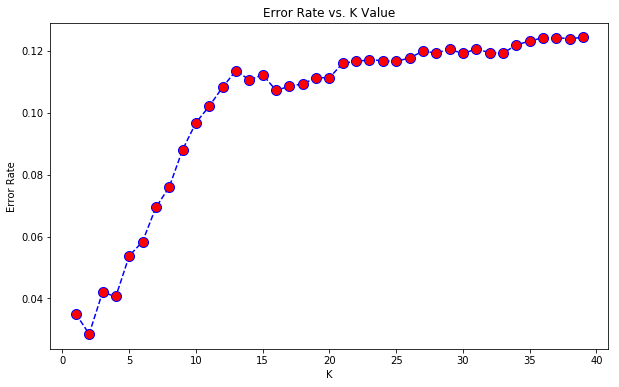

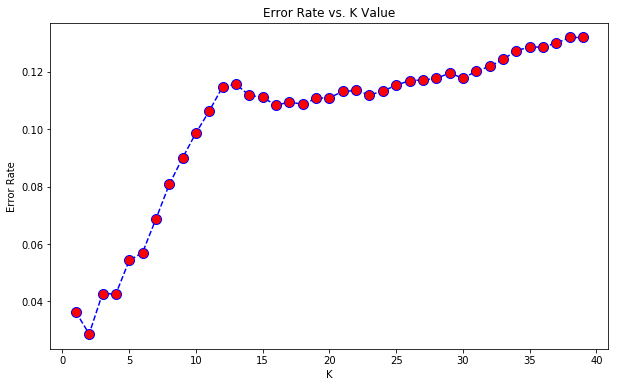

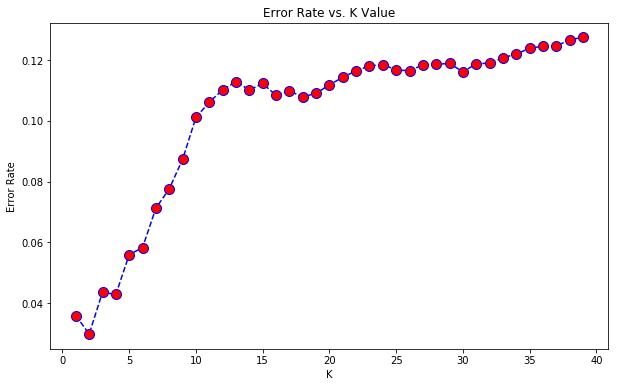

In [47]:
# findBestKForKnn(vectorPartsDfTitles)
# findBestKForKnn(vectorPartsDfDescription)
# findBestKForKnn(vectorPartsDfContents)

In [ ]:
# # best numbers for normal data
# trainKnnClassifier(vectorPartsDfContents, 0.3, 2)
# trainKnnClassifier(vectorPartsDfTitles, 0.3, 10)
# trainKnnClassifier(vectorPartsDfDescription, 0.3, 4)

In [ ]:
# # best numbers for underexpressed 0 class
# trainKnnClassifier(vectorPartsDfContents, 0.3, 1)
# trainKnnClassifier(vectorPartsDfTitles, 0.3, 1)
# trainKnnClassifier(vectorPartsDfDescription, 0.3, 1)

In [48]:
# # best numbers for overexpressed 1 class
# trainKnnClassifier(vectorPartsDfContents, 0.3, 2)
# trainKnnClassifier(vectorPartsDfTitles, 0.3, 2)
# trainKnnClassifier(vectorPartsDfDescription, 0.3, 2)

             precision    recall  f1-score   support

        0.0       0.97      0.96      0.97      5284
        1.0       0.97      0.98      0.97      5938

avg / total       0.97      0.97      0.97     11222

[[5077  207]
 [ 137 5801]]
             precision    recall  f1-score   support

        0.0       0.97      0.96      0.97      5316
        1.0       0.97      0.97      0.97      5906

avg / total       0.97      0.97      0.97     11222

[[5128  188]
 [ 155 5751]]
             precision    recall  f1-score   support

        0.0       0.98      0.96      0.97      5259
        1.0       0.97      0.98      0.97      5963

avg / total       0.97      0.97      0.97     11222

[[5070  189]
 [ 129 5834]]
